In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
from math import cos, sin, sqrt, exp, pi
from matplotlib import animation, rc
from IPython.display import HTML
from random import random, randint, choice
from tqdm import tqdm as tqdm_base

def tqdm(*args, **kwargs):
    if hasattr(tqdm_base, '_instances'):
        for instance in list(tqdm_base._instances):
            tqdm_base._decr_instances(instance)
    return tqdm_base(*args, **kwargs)

# Reacher

## Set Env

In [3]:

#%% region[yellow]
class Reacher:
    def __init__(self, arm_nbr=2, alpha_res=100, x_res=100, reward_reach=100, 
                 reach_distance=0.5, reward_gradient_multiplier=1, respawn_target=False):
        self.arm_nbr = arm_nbr
        self.arm_length = sqrt(2)*x_res/(2*arm_nbr)
        self.alpha_res = alpha_res
        self.x_res = x_res
        self.reward_reach = reward_reach
        self.reach_distance = reach_distance
        self.reward_gradient_multiplier = reward_gradient_multiplier
        self.respawn_target = respawn_target
        self.Rs = {}
        self.Tss = {}
    
    def randomPolicy(self):
        states_pi = {state: choice(self.actions(state)) for state in self.states()}
        return states_pi

    def states(self):
        if self.arm_nbr==1:
            return tuple((alpha1,x1,x2) 
                         for alpha1 in range(self.alpha_res) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2))
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==2:
            return tuple((alpha1,alpha2,x1,x2) 
                         for alpha1 in range(self.alpha_res) 
                         for alpha2 in range(self.alpha_res) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2)) 
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==3:
            return tuple((alpha1,alpha2,alpha3,x1,x2) 
                         for alpha1 in range(self.alpha_res) 
                         for alpha2 in range(self.alpha_res) 
                         for alpha3 in range(self.alpha_res) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2)) 
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))

    def startingStates(self):
        if self.arm_nbr==1:
            return tuple((0,x1,x2) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2)) 
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==2:
            return tuple((0,self.alpha_res/2,x1,x2) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2)) 
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))
        elif self.arm_nbr==3:
            return tuple((0,self.alpha_res/2,self.alpha_res/2,x1,x2) 
                         for x1 in range(int(-self.x_res/2),int(self.x_res/2)) 
                         for x2 in range(int(-self.x_res/2),int(self.x_res/2)))

    def actions(self, state=None):
        if self.arm_nbr==1:
            return tuple(tuple(a1) 
                         for a1 in [-1,0,+1])
        elif self.arm_nbr==2:
            return tuple((a1,a2) 
                         for a1 in [-1,0,+1] 
                         for a2 in [-1,0,+1])
        elif self.arm_nbr==3:
            return tuple((a1,a2,a3) 
                         for a1 in [-1,0,+1] 
                         for a2 in [-1,0,+1] 
                         for a3 in [-1,0,+1]) 

    def R(self, state):
        if state in self.Rs: return self.Rs[state]
        if self.arm_nbr==1:
            alpha1,x1,x2 = state
            alpha1 = 2*pi*alpha1/float(self.alpha_res)
            y1, y2 = (self.arm_length*cos(alpha1) , self.arm_length * sin(alpha1))
        elif self.arm_nbr==2:
            alpha1,alpha2,x1,x2 = state
            alpha1 = 2*pi*alpha1/float(self.alpha_res)
            alpha2 = 2*pi*(alpha2/float(self.alpha_res)-0.5)
            y1,y2 = (self.arm_length*(cos(alpha1)+cos(alpha1+alpha2)) , self.arm_length*(sin(alpha1)+sin(alpha1+alpha2)))
        elif self.arm_nbr==3:
            alpha1,alpha2,alpha3,x1,x2 = state
            alpha1 = 2*pi*alpha1 / float(self.alpha_res)
            alpha2 = 2*pi*(alpha2 / float(self.alpha_res) - 0.5)
            alpha3 = 2*pi*(alpha3 / float(self.alpha_res) - 0.5)
            y1,y2 = (self.arm_length*(cos(alpha1) + cos(alpha1 + alpha2) + cos(alpha1+alpha2+alpha3)), 
                     self.arm_length*(sin(alpha1) + sin(alpha1 + alpha2) + sin(alpha1+alpha2+alpha3)))
        d = sqrt((x1-y1)**2+(x2-y2)**2)
        r = self.reward_reach if d<=self.reach_distance else self.reward_gradient_multiplier*exp(-0.05*d)/self.reward_reach
        self.Rs[state] = r
        return r
    
    def T(self,state,action):
        # if (state,action) in self.Tss: return self.Tss[(state,action)]
        state_t = state
        if self.arm_nbr==1:
            alpha1,x1,x2 = state
            if self.respawn_target:
                y1, y2 = (self.arm_length*cos(2*pi*alpha1/float(self.alpha_res)),
                         self.arm_length*sin(2*pi*alpha1/float(self.alpha_res)))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d <= self.reach_distance:
                    x1 = randint(-self.x_res/2,self.x_res/2-1)
                    x2 = randint(-self.x_res/2,self.x_res/2-1)
            alpha1 += action[0]
            alpha1 %= self.alpha_res
            state = (alpha1,x1,x2)
        elif self.arm_nbr==2:
            alpha1,alpha2,x1,x2 = state
            if self.respawn_target:
                y1,y2 = (self.arm_length*(cos(2*pi*alpha1/float(self.alpha_res))
                                          +cos(2*pi*alpha1/float(self.alpha_res)
                                          +2*pi*(alpha2/float(self.alpha_res)-0.5))), 
                         self.arm_length*(sin(2*pi*alpha1/float(self.alpha_res))
                                          +sin(2*pi*alpha1/float(self.alpha_res)
                                          +2*pi*(alpha2/float(self.alpha_res)-0.5))))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d<=self.reach_distance:
                    x1 = randint(-int(self.x_res/2),int(self.x_res/2)-1)
                    x2 = randint(-int(self.x_res/2),int(self.x_res/2)-1)
            alpha1 += action[0]
            alpha2 += action[1]
            alpha1 %= self.alpha_res
            alpha2 %= self.alpha_res
            state = (alpha1,alpha2,x1,x2)
        elif self.arm_nbr==3:
            alpha1,alpha2,alpha3,x1,x2 = state
            if self.respawn_target:
                y1,y2 = (self.arm_length*(cos(2*pi*alpha1/float(self.alpha_res))
                                          +cos(2*pi*alpha1/float(self.alpha_res)
                                               +2*pi*(alpha2/float(self.alpha_res)-0.5))
                                          +cos(2*pi*alpha1/float(self.alpha_res)
                                               +2*pi*(alpha2/float(self.alpha_res)-0.5)
                                               +2*pi*(alpha3/float(self.alpha_res)-0.5))), 
                         self.arm_length*(sin(2*pi*alpha1/float(self.alpha_res))
                                          +sin(2*pi*alpha1/float(self.alpha_res)
                                               +2*pi*(alpha2/float(self.alpha_res)-0.5))
                                          +sin(2*pi*alpha1/float(self.alpha_res)
                                               +2*pi*(alpha2/float(self.alpha_res)-0.5)
                                               +2*pi*(alpha3/float(self.alpha_res)-0.5))))
                d = sqrt((x1-y1)**2+(x2-y2)**2)
                if d<=self.reach_distance:
                    x1 = randint(-self.x_res/2,self.x_res/2-1)
                    x2 = randint(-self.x_res/2,self.x_res/2-1)
            alpha1 += action[0]
            alpha2 += action[1]
            alpha3 += action[1]
            alpha1 %= self.alpha_res
            alpha2 %= self.alpha_res
            alpha3 %= self.alpha_res
            state = (alpha1,alpha2,alpha3,x1,x2)
        # self.Tss[(state_t,action)] = state
        return state
    
    def Ts(self,state,action):
        return {self.T(state,action):1}
    
    def play(self, states_pi, nbr_turns=0, position=(0,0), display=True, respawn_target=True):
        respawn_target_backup = self.respawn_target
        self.respawn_target = respawn_target
        if nbr_turns==0:
            nbr_turns = 3*self.alpha_res
        state = choice(self.startingStates())
        if position!=(0,0):
            state = (*state[:self.arm_nbr], *position)
        score = 0
        if display:
            fig, ax = plt.subplots()
            ax.set_xlim(-sqrt(2)*self.x_res/2, +sqrt(2)*self.x_res/2)
            ax.set_ylim(-sqrt(2)*self.x_res/2, +sqrt(2)*self.x_res/2)
            arm, = ax.plot([], [], lw=3, marker='o', color="Goldenrod")
            target, = ax.plot([], [], markersize=10, marker='o', color="IndianRed")
            def init():
                arm.set_data([], [])
                return (arm,)
            def animate(i):
                nonlocal state
                nonlocal score
                nonlocal ax
                if state not in states_pi:
                    if display: print("State not in policy : {}".format(state))
                else:
                    action = states_pi[state]
                state = self.T(state,action)
                score += self.R(state)
                if self.arm_nbr==1:
                    alpha1,x1,x2 = state
                    alpha1 = 2*pi*alpha1/float(self.alpha_res)
                    X = [0, self.arm_length*cos(α1)]
                    Y = [0, self.arm_length*sin(α1)]
                elif self.arm_nbr==2:
                    alpha1,alpha2,x1,x2 = state
                    alpha1 = 2*pi*alpha1/float(self.alpha_res)
                    alpha2 = 2*pi*(alpha2/float(self.alpha_res)-0.5)
                    X = [0, self.arm_length*cos(alpha1), self.arm_length*(cos(alpha1)+cos(alpha1+alpha2))]
                    Y = [0, self.arm_length*sin(alpha1), self.arm_length*(sin(alpha1)+sin(alpha1+alpha2))]
                elif self.arm_nbr==3:
                    alpha1,alpha2,alpha3,x1,x2 = state
                    alpha1 = 2*pi*alpha1/float(self.alpha_res)
                    alpha2 = 2*pi*(alpha2/float(self.alpha_res)-0.5)
                    alpha3 = 2*pi*(alpha3/float(self.alpha_res)-0.5)
                    X = [0, self.arm_length*cos(alpha1), self.arm_length*(cos(alpha1)+cos(alpha1+alpha2)), 
                         self.arm_length*(cos(alpha1)+cos(alpha1+alpha2)+cos(alpha1+alpha2+alpha3))]
                    Y = [0, self.arm_length*sin(alpha1), self.arm_length*(sin(alpha1)+sin(alpha1+alpha2)), 
                         self.arm_length*(sin(alpha1)+sin(alpha1+alpha2)+sin(alpha1+alpha2+alpha3))]
                arm.set_data(X, Y)
                target.set_data([x1],[x2])
                ax.set_title("Score : {:0.2f}".format(score))
                return (arm,)
            anim = animation.FuncAnimation(fig, animate, init_func=init, frames=nbr_turns, interval=100, blit=True)
            HTML(anim.to_jshtml())
            self.respawn_target = respawn_target_backup
            return score, anim
        else:
            for _ in range(nbr_turns):
                if state not in states_pi:
                    if display: print("State not in policy")
                else:
                    action = states_pi[state]
                state = self.T(state,action)
                score += self.R(state)
            self.respawn_target = respawn_target_backup
        return score

    def performance(self, states_pi, nbr_runs=200, nbr_turns=0, respawn_target=True):
        scores = []
        for run in tqdm(range(nbr_runs)):
            scores.append(self.play(states_pi, nbr_turns, display=False, respawn_target=respawn_target))
        return min(scores) , sum(scores)/len(scores) , max(scores)
#endregion


In [4]:
def policyDistance(states_pi1,states_pi2):
    return np.linalg.norm(np.array(list(states_pi1.values()))-np.array(list(states_pi2.values())))




#%% region[red] VALUE ITERATION
def valueIteration(mdp, e, gama, max_iter=1000, record=True, verbose=True):
    rec = []
    itr = 0
    Us = {state: 0 for state in mdp.states()}
    states_pi = mdp.randomPolicy()
    dleta = 2*e
    if record: 
        rec.append((mdp.performance(states_pi), 0))
    while dleta > e and itr < max_iter:
        print("Iteration #{}".format(itr))
        dleta = 0
        states_pi_temp = states_pi.copy()
        for state in tqdm(mdp.states()):
            U_temp = Us[state]
            U_max = 0
            for action in mdp.actions(state):
                Ts = mdp.Ts(state, action)
                U_max_temps = sum([Ts[state_t]*(mdp.R(state_t)+gama*Us[state_t]) for state_t in Ts.keys()])
                if U_max_temps > U_max:
                    U_max = U_max_temps
                    states_pi[state] = action
            dleta = max(dleta, abs(U_temp-U_max))
            Us[state] = U_max
        if record: rec.append((mdp.performance(states_pi), policyDistance(states_pi,states_pi_temp)))
        if verbose: print("dleta = {}\nperf = {}".format(dleta,mdp.performance(states_pi)))
        itr +=1
    return states_pi, rec

In [5]:
def policyIteration(mdp, gama, eval_iter, max_iter, record=True, verbose=True):
    rec = []
    Us = {state: 0 for state in mdp.states()}
    states_pi = {state: choice(mdp.actions(state)) for state in mdp.states()}
    states_pi = mdp.randomPolicy()
    if record: rec.append((mdp.performance(states_pi), 0))
    for itr in range(max_iter):
        if verbose: print("Iteration #{}".format(itr))
        Us = policyEvaluation(mdp, gama, Us, states_pi, eval_iter, verbose)
        states_pi_temp = states_pi.copy()
        states_pi = policyImprovement(mdp, gama, Us, states_pi)
        if record: rec.append((mdp.performance(states_pi), policyDistance(states_pi,states_pi_temp)))
        if verbose: print("perf = {}".format(mdp.performance(states_pi)))
        if (states_pi_temp==states_pi):
            break
    return states_pi, rec

def policyEvaluation(mdp, gama, Us, states_pi, eval_iter, verbose=True):
    for _ in tqdm(range(eval_iter)):
        for state in mdp.states():
            action = states_pi[state]
            Ts = mdp.Ts(state, action)
            Us[state] = sum([Ts[state_t]*(mdp.R(state_t)+gama*Us[state_t]) for state_t in Ts.keys()])
    return Us

def policyImprovement(mdp, gama, Us, states_pi):
    for state in tqdm(mdp.states()):
        states_pi_temp = states_pi.copy()
        U_max = 0
        for action in mdp.actions(state):
            Ts = mdp.Ts(state, action)
            U_max_temps = sum([Ts[state_t]*(mdp.R(state_t)+gama*Us[state_t]) for state_t in Ts.keys()])
            if U_max_temps > U_max:
                U_max = U_max_temps
                states_pi[state] = action
    return states_pi




# %% region[green] Q LEARNING
def Qlearning(mdp, gama, alpha, qpolicy, qpolicy_args={}, qinit=0, nbr_turns=100, nbr_episode=1000, rec_period=100, record=True, verbose=True):
    rec = []
    Qs = {(state,action):qinit for state in mdp.states() for action in mdp.actions(state)}
    states_pi = mdp.randomPolicy()
    if record: rec.append((mdp.performance(states_pi), 0))
    for episode in tqdm(range(1,nbr_episode+1)):
        states_pi_temp = states_pi
        for state in mdp.startingStates():
            for turn in range(nbr_turns):
                action = qpolicy(mdp, Qs, state, **qpolicy_args)
                # Q_temp = Qs[(state,action)]
                Ts = mdp.Ts(state,action)
                rng = random()
                p_accumul = 0
                for next_state, p in Ts.items():
                    p_accumul += p
                    if rng <= p_accumul:
                        break
                R = mdp.R(next_state)
                Qs[(state,action)] += alpha * (R + gama*max([Qs[(next_state,action_t)] for action_t in mdp.actions(next_state)]) - Qs[(state,action)])
                state = next_state
        states_pi = {state:qpolicy(mdp, Qs, state, **qpolicy_args) for state in mdp.states()}
        if record and episode%rec_period==0: rec.append((mdp.performance(states_pi,nbr_runs=120), policyDistance(states_pi,states_pi_temp)))
        if verbose: print("perf = {}".format(mdp.performance(states_pi)))
    return states_pi, rec

def eGreedy(mdp, Qs, state, epsilon):
    rng = random()
    if rng>epsilon:
        Q_max = -99999999
        for act in mdp.actions(state):
            Q_temp = Qs[(state,act)]
            if Q_temp>Q_max:
                Q_max = Q_temp
                action = act
    else:
        action = choice(mdp.actions(state))
    return action

def epRandom(mdp, Qs, state, epsilon=0.2):
    rng = random()
    ep = epsilon/float(len(mdp.actions(state)))
    Q_sum = sum([Qs[(state,act)] for act in mdp.actions(state)]) + 0.00001
    ps = {act:ep+(1-epsilon)*(Qs[(state,act)]+0.00001/float(len(mdp.actions(state))))/Q_sum for act in mdp.actions(state)}
    rng = random()
    p_accumul = 0
    for action, p in ps.items():
        p_accumul += p
        if rng <= p_accumul:
            break
    return action

def ebetapRandom(mdp, Qs, state, epsilon=0.1, beta=2):
    rng = random()
    ep = epsilon/float(len(mdp.actions(state)))
    Q_sum = sum([Qs[(state,act)]**beta for act in mdp.actions(state)]) + 0.00001
    ps = {act:ep+(1-epsilon)*(Qs[(state,act)]**beta+0.00001/float(len(mdp.actions(state))))/Q_sum for act in mdp.actions(state)}
    rng = random()
    p_accumul = 0
    for action, p in ps.items():
        p_accumul += p
        if rng <= p_accumul:
            break
    return action


In [6]:
def analysis_gama(records):
#     gamas = [0.2,0.5,0.75,0.9,0.99]

    plotArgs = {'γ=0.20':{'dashes':[7,1]}, 'γ=0.50':{'dashes':[5,1]}, 'γ=0.75':{'dashes':[3,1]}, 'γ=0.90':{'dashes':[1,1]}, 'γ=0.99':{'dashes':[2,0]}, 'default':{'dashes':[2,0]}}
    # plotArgs = {'ε=0.00':{'alpha':1}, 'ε=0.25':{'alpha':0.8}, 'ε=0.50':{'alpha':0.6}, 'ε=0.75':{'alpha':0.4}, 'ε=1.00':{'alpha':0.2}, 'default':{'dashes':[2,0]}}
    # plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[2,0]}}
#     plotArgs = {'Optimistic init':{'dashes':[2,0]}, 'e-Greedy':{'dashes':[5,1]}, 'ep-Random':{'dashes':[3,1]}, 'ebetap-Random':{'dashes':[1,1]}, 'default':{'dashes':[2,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:20]
        dists = dists[:21]
        plt.figure(1)
#         plt.plot(range(len(perfs)), [entry[1] for entry in perfs], color="IndianRed", linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))

        plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()

In [35]:
def analysis(records):
    # plotArgs = {'γ=0.50':{'dashes':[2,1]}, 'γ=0.90':{'dashes':[4,1]}, 'γ=0.99':{'dashes':[2,0]}, 'default':{'dashes':[2,0]}}
    # plotArgs = {'ε=0.00':{'alpha':1}, 'ε=0.25':{'alpha':0.8}, 'ε=0.50':{'alpha':0.6}, 'ε=0.75':{'alpha':0.4}, 'ε=1.00':{'alpha':0.2}, 'default':{'dashes':[2,0]}}
    # plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[2,0]}}
    plotArgs = {'Optimistic init':{'dashes':[2,0]}, 'ε-Greedy':{'dashes':[5,1]}, 'ερ-Random':{'dashes':[3,1]}, 'εβρ-Random':{'dashes':[1,1]}, 'default':{'dashes':[2,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:20]
        dists = dists[:21]
        plt.figure(1)
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        # plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], color="IndianRed", alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()

In [36]:
def analysis_e(records):
#     gamas = [0.2,0.5,0.75,0.9,0.99]

    plotArgs = {'ε=0.00':{'alpha':1}, 'ε=0.25':{'alpha':0.8}, 'ε=0.50':{'alpha':0.6}, 'ε=0.75':{'alpha':0.4}, 'ε=1.00':{'alpha':0.2}, 'default':{'dashes':[2,0]}}
    # plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[2,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:20]
        dists = dists[:21]
        plt.figure(1)
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        # plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], color="IndianRed", alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()

In [37]:
def analysis_alpha(records):
#     gamas = [0.2,0.5,0.75,0.9,0.99]

    plotArgs = {'α=0.01':{'alpha':1}, 'α=0.04':{'alpha':0.8}, 'α=0.10':{'alpha':0.6}, 'α=0.25':{'alpha':0.4}, 'α=0.50':{'alpha':0.2}, 'α=0.90':{'alpha':0.1}, 'default':{'dashes':[2,0]}}
    for label,rec in records.items():
        perfs, dists = zip(*rec)
        perfs = perfs[:20]
        dists = dists[:21]
        plt.figure(1)
        plt.plot(range(len(perfs)), [entry[1] for entry in perfs], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        # plt.fill_between(range(len(perfs)), [entry[0] for entry in perfs], [entry[2] for entry in perfs], color="IndianRed", alpha=0.15)
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.legend()
        plt.figure(2)
        plt.plot(range(1,len(dists)), dists[1:], linewidth=3, label=label, **plotArgs.get(label, plotArgs['default']))
        plt.xlabel("Iteration")
        plt.ylabel("Policy change")
        plt.legend()
    plt.show()

## Value Iteration

### 1. arm 2, alpha res 60,  reward_gradient 1

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2399.49it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1303.91it/s]


dleta = 25.0
perf = (6.832260576980764, 68.63092890005787, 227.70311728637458)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1180.67it/s]


dleta = 5.0
perf = (147.59207551822465, 257.8047595581466, 387.318800620723)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1204.72it/s]


dleta = 0.9999872000000005
perf = (167.4901630377443, 259.9043343175015, 387.371035602259)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1163.74it/s]


dleta = 0.1999974400000003
perf = (147.5814129827577, 257.3069508066557, 387.22816875814004)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1210.82it/s]


dleta = 0.03999948800000008
perf = (147.46039073465718, 266.59587444365366, 387.24517243728997)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1196.89it/s]


dleta = 0.007999897600000028
perf = (167.54967314123638, 262.3078806602726, 367.36012103818507)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1039.91it/s]


dleta = 0.0015999795200000166
perf = (147.71963908635283, 261.2013609093351, 387.3567463619771)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1068.22it/s]


dleta = 0.00031999590400000333
perf = (167.47839105182672, 260.20630851205226, 387.334553527862)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2227.97it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1189.37it/s]


dleta = 40.0
perf = (6.832260576980764, 68.55063525180655, 227.46744239060388)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1067.27it/s]


dleta = 20.0
perf = (167.43508007403747, 257.70343939377216, 407.26139439898714)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1074.24it/s]


dleta = 9.921875000000002
perf = (167.58110418669506, 257.6034625794618, 387.27990536000084)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1042.25it/s]


dleta = 4.960937500000001
perf = (167.5182952643805, 262.69656520637903, 387.24190026698784)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1100.15it/s]


dleta = 2.480468750000001
perf = (167.5967667959563, 263.7841957834092, 367.42419710169077)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1177.74it/s]


dleta = 1.2402343750000004
perf = (147.53985761087444, 260.40129717001776, 367.41715391668635)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 924.65it/s]


dleta = 0.6201171875000002
perf = (147.5269821366318, 267.98573803261866, 407.3808742670821)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1178.79it/s]


dleta = 0.3100585937500001
perf = (167.52121432326817, 262.28592448216614, 387.32486359053917)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1188.78it/s]


dleta = 0.15502929687500006
perf = (187.388180598614, 268.77336007647386, 367.43131762689745)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1187.56it/s]


dleta = 0.07751464843750006
perf = (147.59423342147372, 271.4818630233165, 387.33147080264075)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1240.52it/s]


dleta = 0.03875732421875003
perf = (167.54772907762955, 261.1787513999417, 387.31963304813314)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1224.85it/s]


dleta = 0.019378662109375014
perf = (167.52471718343278, 268.77441053222907, 387.3388040001439)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1211.55it/s]


dleta = 0.009689331054687514
perf = (167.6030509309064, 275.36518462776564, 407.35174132160586)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1261.58it/s]


dleta = 0.004844665527343764
perf = (167.54801061889086, 268.7728990150239, 407.38895460039674)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1228.05it/s]


dleta = 0.002422332763671875
perf = (187.41001751469673, 266.375954520046, 367.3472605903888)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1205.81it/s]


dleta = 0.0012111663818359375
perf = (187.42497026400406, 268.8744327787337, 407.2867376264742)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1241.51it/s]


dleta = 0.0006055831909179688
perf = (187.44942047925596, 270.96797758782054, 407.26688555952614)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2673.83it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1386.04it/s]


dleta = 79.99999999999996
perf = (6.832260576980764, 72.05386101602384, 247.6163457180204)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1254.88it/s]


dleta = 59.99999999999994
perf = (127.64468253431272, 203.25395738003274, 307.46473747123815)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1251.09it/s]


dleta = 38.99322509765625
perf = (127.28706831376968, 214.1328887729687, 327.3617701235872)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1198.98it/s]


dleta = 29.244918823242188
perf = (147.3945552145583, 221.1253380918446, 347.3841383240212)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1123.83it/s]


dleta = 21.933689117431644
perf = (147.57508708177932, 231.41575258632542, 347.37767343162915)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1195.37it/s]


dleta = 16.45026683807373
perf = (147.40022695783986, 236.78846507542224, 367.32868865154234)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1221.08it/s]


dleta = 12.337700128555298
perf = (147.45733568672748, 241.68469683865985, 387.3631189087706)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1226.25it/s]


dleta = 9.253275096416475
perf = (147.43028932643236, 248.57023551439022, 367.3886499096994)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1214.08it/s]


dleta = 6.939956322312357
perf = (167.40617398247215, 251.67660175540684, 387.261487733156)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1252.09it/s]


dleta = 5.204967241734268
perf = (167.61890942760388, 259.5649340994507, 367.4412753562655)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1237.86it/s]


dleta = 3.903725431300701
perf = (167.46976731687758, 257.65538547425984, 387.37647021679453)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1186.98it/s]


dleta = 2.9277940734755252
perf = (167.46134789242018, 266.5581591811568, 407.2854763915726)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1246.15it/s]


dleta = 2.195845555106644
perf = (167.4718652189122, 266.2420278579439, 387.3385519098916)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1220.14it/s]


dleta = 1.6468841663299827
perf = (187.47187203318444, 266.951623150864, 387.2281976259118)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1237.01it/s]


dleta = 1.235163124747487
perf = (187.39485163509806, 268.84990120875256, 407.2684564628153)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1194.14it/s]


dleta = 0.9263723435606154
perf = (167.48266381338192, 269.54717414511947, 407.3781515193751)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1181.72it/s]


dleta = 0.6947792576704618
perf = (167.4997419094165, 272.14910651973145, 407.2895118423467)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1213.40it/s]


dleta = 0.5210844432528463
perf = (187.46878005543448, 271.74146708776664, 407.25501105824253)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1097.72it/s]


dleta = 0.39081333243963456
perf = (187.4426588794477, 271.65542816812905, 387.1830127013726)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1173.24it/s]


dleta = 0.2931099993297259
perf = (187.40084791896751, 276.3462369997426, 387.40750996249176)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1195.87it/s]


dleta = 0.21983249949729447
perf = (187.24687961569498, 274.146429437976, 407.1437419891712)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1216.01it/s]


dleta = 0.1648743746229709
perf = (187.3791513006161, 275.1511231036166, 367.43100319442703)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1149.38it/s]


dleta = 0.12365578096722807
perf = (187.37928053871147, 273.7566397837921, 387.38279617021817)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1186.66it/s]


dleta = 0.08797964665422067
perf = (187.3352736685842, 275.4465277644407, 407.21370435693785)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1163.91it/s]


dleta = 0.059448996061721826
perf = (187.318824340261, 277.5394487285514, 427.24596927143864)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1201.17it/s]


dleta = 0.04115472036839854
perf = (187.42013201179736, 276.75902447556035, 407.3403514817557)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1207.84it/s]


dleta = 0.03086604027629883
perf = (207.4513740174057, 277.45061094909477, 367.3775699806876)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1234.53it/s]


dleta = 0.017362147655418103
perf = (207.32365480658538, 277.44920877041693, 367.46391264446265)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1214.82it/s]


dleta = 0.009766208056172732
perf = (187.54241286911255, 276.64297485972236, 387.2768984516124)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1190.54it/s]


dleta = 0.006309848702433868
perf = (187.42045522516474, 275.1498774078477, 427.2992608031359)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1167.45it/s]


dleta = 0.0023175669508300745
perf = (207.24205369059484, 277.8391397014753, 387.32690468164157)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1192.31it/s]


dleta = 0.0007332926680360397
perf = (167.45450412074464, 272.35500666133436, 427.2403509590751)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2554.19it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1280.18it/s]


dleta = 199.9994768621451
perf = (6.832260576980764, 68.69212503124648, 207.69360702818548)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1124.98it/s]


dleta = 179.99941873571677
perf = (127.20713241766862, 188.45831543855442, 287.4270297967759)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1134.74it/s]


dleta = 84.5159022
perf = (127.43439553288276, 197.13786111625276, 307.51885784535864)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1143.59it/s]


dleta = 76.06431198000001
perf = (107.32708723429106, 201.8262587889792, 327.49173353322703)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1137.92it/s]


dleta = 68.45788078200002
perf = (127.33604831431944, 200.1142867362461, 347.42580841186304)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1128.93it/s]


dleta = 61.61209270380001
perf = (107.30415618543476, 212.1102566982041, 387.4241580741382)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1164.51it/s]


dleta = 55.450883433420024
perf = (127.54473086821942, 223.69378081518298, 347.4706107138241)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1129.04it/s]


dleta = 49.90579509007802
perf = (147.31768939921898, 225.37921230358046, 327.55285886516157)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1218.63it/s]


dleta = 44.915215581070214
perf = (127.64094688014343, 234.77000794105825, 367.3363519248435)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1219.75it/s]


dleta = 40.42369402296318
perf = (147.332953911804, 239.75733355842047, 367.31897630919315)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1254.45it/s]


dleta = 36.38132462066687
perf = (167.30947787575084, 241.56517030946677, 387.34578739934125)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1201.04it/s]


dleta = 32.03511493487584
perf = (147.4402328966966, 249.06168701969355, 427.3110489490973)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1208.79it/s]


dleta = 27.57980816799696
perf = (147.42102055233528, 246.8596993057571, 367.4191397611351)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1179.29it/s]


dleta = 23.820282213120176
perf = (167.41553256841695, 258.8479680810352, 367.4640338432116)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1208.32it/s]


dleta = 20.502759329699067
perf = (147.48884382986816, 257.25208638097274, 347.40564779541745)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1192.99it/s]


dleta = 17.364985733364584
perf = (167.47797578651756, 260.04274666193214, 367.31283533785137)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1172.28it/s]


dleta = 15.176605950734352
perf = (147.43866061545114, 264.04657832532155, 407.3368006417259)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1208.11it/s]


dleta = 13.65894535566092
perf = (187.35365140772223, 266.13955309851895, 387.3397360053577)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1197.35it/s]


dleta = 11.648504084462559
perf = (187.4681229240689, 271.3445263418817, 407.19478367000994)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1191.89it/s]


dleta = 9.957371164276807
perf = (187.35588573283275, 272.8447547351693, 427.3221432388347)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1154.10it/s]


dleta = 8.56400407312678
perf = (167.39261093691604, 271.3527311441923, 387.4868552886733)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1161.93it/s]


dleta = 6.773254265218877
perf = (167.4385272488287, 271.75125802312976, 407.30968505751684)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 280.83it/s]


dleta = 5.759117584433334
perf = (167.50696244748525, 273.6513960879574, 367.39439937587605)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1136.77it/s]


dleta = 4.777088414635282
perf = (207.35980312681025, 276.34772846925404, 407.2860301443232)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1208.63it/s]


dleta = 3.999538911069102
perf = (187.4546074850079, 272.5544183565791, 367.36570620795294)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1160.52it/s]


dleta = 3.5995850199621913
perf = (187.48965616522656, 275.4496373998516, 367.4251290527229)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1177.00it/s]


dleta = 2.689912308710646
perf = (187.35360143093206, 273.4456787412262, 407.2778872213805)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1162.61it/s]


dleta = 2.125518958437471
perf = (187.4233074583154, 273.45893070107485, 427.3102869876299)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1186.73it/s]


dleta = 1.7216703563343536
perf = (207.3329113790949, 275.6364985360402, 407.303556886752)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1169.03it/s]


dleta = 1.2550976897677533
perf = (187.3157992670924, 271.0508237993529, 407.40752859647023)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1160.56it/s]


dleta = 0.9149662158406908
perf = (187.38769598200216, 280.1404795425748, 387.3169248880182)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1218.31it/s]


dleta = 0.7041959073875432
perf = (187.4839516649713, 275.4530410038241, 387.28765723488306)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1171.53it/s]


dleta = 0.4862505607125911
perf = (187.55438545310884, 270.15720062486173, 387.25081267377215)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1194.66it/s]


dleta = 0.3938629541772052
perf = (187.31727766570674, 273.55244517278265, 367.32071675065777)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1246.58it/s]


dleta = 0.2584134842356498
perf = (187.3495021625382, 276.745856849811, 387.44079277187456)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1134.69it/s]


dleta = 0.16954508700701965
perf = (167.49329098302042, 271.450309105445, 367.36143779134255)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1172.35it/s]


dleta = 0.1112385315853075
perf = (187.44368926223694, 268.4618650154578, 387.21916503803106)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.11it/s]


dleta = 0.07298360057311015
perf = (187.27170282664383, 274.3616912009507, 367.32044499484385)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1192.92it/s]


dleta = 0.04788454033602818
perf = (187.54719081537476, 273.25550622894707, 407.3030712665594)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 808.77it/s]


dleta = 0.031417046914464564
perf = (187.3693793050914, 275.344307593948, 407.2139851612704)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1348.41it/s]


dleta = 0.02061272448057494
perf = (187.41460089775487, 270.5514990126728, 367.21846287827844)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1225.23it/s]


dleta = 0.013524008531714315
perf = (207.3145342598437, 275.54843339497586, 367.3682399133402)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1123.66it/s]


dleta = 0.008873101997656008
perf = (187.37489264710248, 272.45846262665987, 367.3917136402335)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1261.79it/s]


dleta = 0.007187212618100958
perf = (167.4514357000619, 273.24334703812286, 387.3376232871002)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1091.09it/s]


dleta = 0.00471553019873916
perf = (187.44470916181186, 276.0470122051363, 387.2753676184165)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1160.58it/s]


dleta = 0.003093859363380247
perf = (187.45626050818584, 273.9663596556375, 387.2762044585216)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1136.37it/s]


dleta = 0.0020298811283190332
perf = (187.46536961228918, 273.6480421850619, 387.2781002024014)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1069.66it/s]


dleta = 0.0013318050082915533
perf = (167.4963065115586, 272.65751466649215, 367.3482770955791)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1080.45it/s]


dleta = 0.0008737972659407234
perf = (187.37458271312107, 266.1598376004943, 367.34958968117695)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2067.58it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1265.10it/s]


dleta = 1421.2107408530196
perf = (6.804413978874649, 66.96665103565752, 207.5504045573066)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1295.98it/s]


dleta = 1395.3643847000199
perf = (87.43159159462415, 160.09711224387354, 247.35227950336355)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1317.74it/s]


dleta = 487.74010655909933
perf = (107.39079851676236, 169.40168809629887, 267.51580277403946)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1148.63it/s]


dleta = 156.07963397597177
perf = (87.37885693485745, 170.2113141719288, 307.4350325946252)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1149.12it/s]


dleta = 87.87322072931727
perf = (107.44867252003642, 175.39745507718035, 267.51086543304336)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1082.11it/s]


dleta = 86.12454363680382
perf = (87.49292385199216, 175.19857166324564, 267.5592180068274)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1321.28it/s]


dleta = 83.56655856624712
perf = (107.39020615492535, 178.48796841713963, 287.51994194296407)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1309.45it/s]


dleta = 75.67924062652338
perf = (107.54278652351216, 184.68688261793935, 267.6608107737127)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1271.25it/s]


dleta = 71.19618346923795
perf = (107.6241397233412, 184.16716021820346, 267.53618900809806)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1153.64it/s]


dleta = 67.92685766319096
perf = (107.4081200395937, 182.9563991052715, 307.36211449461763)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1401.00it/s]


dleta = 63.311424186496936
perf = (107.52310801427917, 186.45623364788437, 327.40743734978315)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1186.60it/s]


dleta = 57.00309049245965
perf = (107.52048399373703, 191.96700697566337, 307.465255755021)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1280.15it/s]


dleta = 55.310041701743216
perf = (107.46627493043823, 193.0504184112747, 287.40263286396515)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1301.70it/s]


dleta = 54.081057388033855
perf = (127.44971927008966, 193.33999444044233, 287.5427668349974)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1187.91it/s]


dleta = 52.47479590255182
perf = (127.42355686245355, 197.64394022924222, 307.5410852537467)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1207.03it/s]


dleta = 51.430547464090864
perf = (107.4505379917497, 201.12533888353772, 347.4028663883869)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1219.25it/s]


dleta = 49.90300877386005
perf = (107.46734596465465, 200.624505448407, 327.4836704766738)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1095.55it/s]


dleta = 48.420839510267456
perf = (127.45512033844881, 204.83511960336224, 307.50220055693114)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 999.15it/s]


dleta = 47.45726480401288
perf = (127.53731741492145, 207.9067742071364, 287.59352180562956)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1230.39it/s]


dleta = 45.58725921624875
perf = (127.51311760636979, 207.51382571909912, 347.3225121451741)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1153.81it/s]


dleta = 44.68007275784521
perf = (127.30568670731436, 209.12599929233812, 347.47764681314425)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1168.31it/s]


dleta = 43.35302991686456
perf = (127.5860257635104, 213.81221932705353, 307.3881106607182)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1193.61it/s]


dleta = 42.06540157530378
perf = (127.3509945854384, 214.307600961282, 367.3042696249753)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1193.20it/s]


dleta = 40.87880145793963
perf = (127.21171860838486, 213.41151266637596, 387.29292850598273)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1139.34it/s]


dleta = 39.60374055973011
perf = (127.38547867024396, 222.90472860489612, 367.2994972725979)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1229.31it/s]


dleta = 38.815626122591425
perf = (147.50272154985367, 218.596251478854, 347.2620215904902)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1224.67it/s]


dleta = 37.66276321112434
perf = (127.59893918224432, 221.69360753332145, 347.26663588175256)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1212.60it/s]


dleta = 36.54414148099033
perf = (127.56801326243367, 222.20179561459244, 367.3788528774021)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1152.06it/s]


dleta = 35.816913065518634
perf = (147.4182024434677, 226.1905744282537, 367.32619282115354)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1220.57it/s]


dleta = 34.405583781254904
perf = (147.436825744252, 233.08037772663548, 367.42302991547973)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1209.68it/s]


dleta = 33.38370353736775
perf = (147.36350154787186, 234.17699045598695, 347.3467054188375)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1220.86it/s]


dleta = 32.71936783697345
perf = (147.4487150475406, 230.8863230308351, 327.4620813235535)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1173.45it/s]


dleta = 31.43009419391933
perf = (127.59842592069482, 232.5775653655494, 367.41997730876216)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1207.54it/s]


dleta = 30.80463531946043
perf = (127.39786148684834, 236.28470249272345, 407.23388662299953)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1157.97it/s]


dleta = 29.889706845836827
perf = (147.30344213590752, 236.67559618481343, 367.36443505252373)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1184.52it/s]


dleta = 28.71193313618096
perf = (127.47969844610233, 246.17732528268155, 347.44464916934527)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1211.43it/s]


dleta = 28.140565666770954
perf = (147.26778921175801, 242.86971471425488, 367.423064416412)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1226.77it/s]


dleta = 27.30476272590181
perf = (127.57008691457627, 241.9776318357353, 347.53050578879504)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1191.29it/s]


dleta = 26.228846128498617
perf = (147.52678616138175, 242.37162233157932, 367.31857562062265)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1207.91it/s]


dleta = 25.706892090540805
perf = (147.40999518654183, 241.37432040335773, 387.36364890091136)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1211.99it/s]


dleta = 24.94337168856009
perf = (147.45247340868048, 245.17017264265087, 387.392368084381)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1200.20it/s]


dleta = 23.960503319977988
perf = (167.39480089006292, 246.96804476442685, 367.34920234701445)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1117.17it/s]


dleta = 23.248852410870995
perf = (167.42807872096895, 244.46203419939212, 367.413798346488)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1160.64it/s]


dleta = 22.78620024789484
perf = (167.4376309928893, 248.07095997429076, 347.47460924967726)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1225.90it/s]


dleta = 21.888333041188844
perf = (147.2930540028493, 248.8603318913777, 427.30997785135935)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1176.65it/s]


dleta = 21.025845384917147
perf = (167.3966094011231, 251.26486381095384, 407.37709981340043)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1149.58it/s]


dleta = 20.815586931067628
perf = (167.59013966505768, 253.67221751449284, 387.27036202581684)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1142.13it/s]


dleta = 19.99536975179126
perf = (167.45983225921435, 254.2589329320103, 367.3536326848117)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1073.37it/s]


dleta = 19.207472402045823
perf = (167.52466630225817, 254.55755132796364, 347.46807155733563)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1079.22it/s]


dleta = 18.636991264233302
perf = (167.3286160566803, 258.4563402239946, 367.4810264527384)


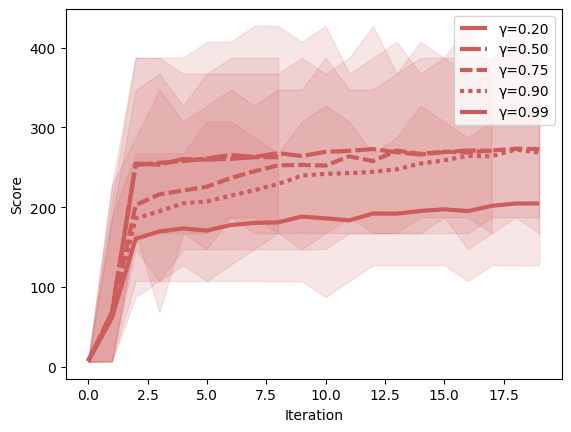

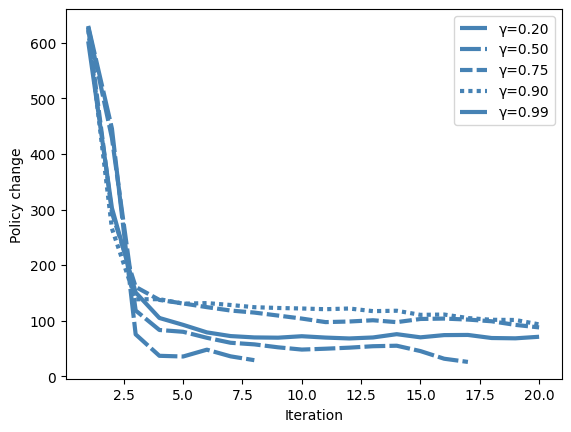

In [11]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20, reward_gradient_multiplier=1)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

{'γ=0.20': [((6.168359242598035, 7.056405476538988, 8.128623025160312), 0), ((6.832260576980764, 68.89578048161593, 207.73865430718377), 630.5227989533764), ((167.51655695888616, 254.7146368254111, 387.3638716575084), 445.73422574444515), ((68.17917811719413, 253.32357796757572, 387.2469204865613), 75.2329714952161), ((167.5269003643479, 260.4032952597963, 367.41373286860636), 36.64696440361739), ((147.5091586232138, 259.7062634556916, 367.3631142181326), 35.38361202590826), ((187.42613796612468, 260.60809388740404, 387.2390634470164), 47.67598976424087), ((187.54118861209366, 262.7035499681318, 387.34203062152034), 35.66510900025401), ((167.60104388512707, 262.8000625858772, 387.4098499985359), 28.75760768909681)], 'γ=0.50': [((6.0581916231081, 6.983187110911064, 8.045335986617147), 0), ((6.832260576980764, 66.97384515277936, 227.6232648412409), 628.3120243955228), ((167.56145250466327, 252.9069979838804, 387.42185812331417), 428.7831619828372), ((167.55072787556043, 255.6026178132143

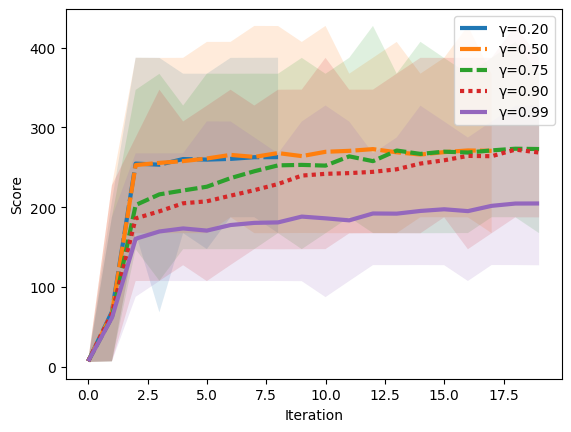

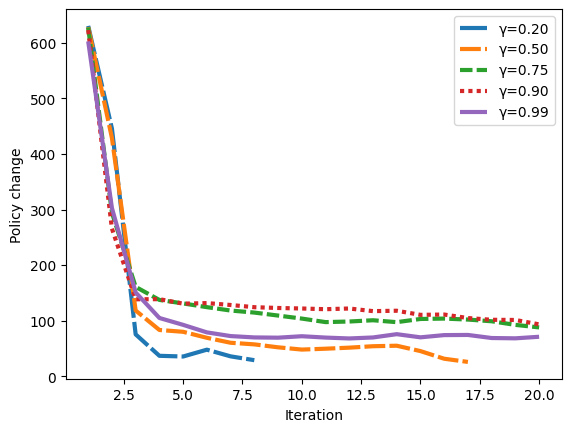

In [23]:
filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
print(records)
analysis_gama(records)

### 2. arm 2, alpha res 60,  reward_gradient 0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2712.21it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1642.99it/s]


dleta = 25.0
perf = (0.0, 45.3, 220.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1380.92it/s]


dleta = 5.0
perf = (120.0, 182.4, 300.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1367.90it/s]


dleta = 0.9999872000000005
perf = (120.0, 194.7, 320.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1356.47it/s]


dleta = 0.19999744000000008
perf = (120.0, 196.9, 320.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1312.13it/s]


dleta = 0.039999488
perf = (120.0, 209.9, 420.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1200.83it/s]


dleta = 0.0079998976
perf = (140.0, 214.1, 360.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1155.38it/s]


dleta = 0.0015999795200000002
perf = (140.0, 223.4, 340.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1206.26it/s]


dleta = 0.0003199959040000001
perf = (140.0, 232.7, 360.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2199.26it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1395.69it/s]


dleta = 40.0
perf = (0.0, 49.5, 240.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1226.46it/s]


dleta = 20.0
perf = (120.0, 186.4, 280.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1092.11it/s]


dleta = 9.921875
perf = (120.0, 192.4, 340.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1039.88it/s]


dleta = 4.9609375
perf = (120.0, 201.9, 320.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1126.74it/s]


dleta = 2.48046875
perf = (120.0, 206.4, 360.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1122.06it/s]


dleta = 1.240234375
perf = (120.0, 213.5, 320.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1074.70it/s]


dleta = 0.6201171875
perf = (140.0, 215.1, 320.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1155.96it/s]


dleta = 0.31005859375
perf = (140.0, 227.7, 380.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1029.12it/s]


dleta = 0.155029296875
perf = (140.0, 239.3, 360.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1094.60it/s]


dleta = 0.0775146484375
perf = (140.0, 237.2, 360.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1115.11it/s]


dleta = 0.03875732421875
perf = (160.0, 242.4, 420.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1146.71it/s]


dleta = 0.019378662109375
perf = (140.0, 247.8, 360.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1166.77it/s]


dleta = 0.0096893310546875
perf = (160.0, 247.9, 400.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1208.10it/s]


dleta = 0.00484466552734375
perf = (180.0, 260.1, 420.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1198.36it/s]


dleta = 0.002422332763671875
perf = (160.0, 260.1, 400.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1236.27it/s]


dleta = 0.0012111663818359375
perf = (140.0, 258.5, 380.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1200.28it/s]


dleta = 0.0006055831909179688
perf = (180.0, 263.1, 420.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2504.29it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1300.22it/s]


dleta = 79.99999999999996
perf = (0.0, 47.4, 240.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1169.54it/s]


dleta = 59.99999999999994
perf = (100.0, 184.1, 340.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1259.68it/s]


dleta = 38.99322509765625
perf = (120.0, 193.7, 340.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1169.23it/s]


dleta = 29.244918823242188
perf = (100.0, 199.6, 320.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1239.52it/s]


dleta = 21.93368911743164
perf = (120.0, 201.6, 340.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1165.45it/s]


dleta = 16.45026683807373
perf = (120.0, 211.0, 320.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1097.21it/s]


dleta = 12.337700128555298
perf = (140.0, 222.0, 380.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1204.80it/s]


dleta = 9.253275096416473
perf = (140.0, 224.5, 460.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1149.93it/s]


dleta = 6.939956322312355
perf = (160.0, 234.1, 420.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1114.02it/s]


dleta = 5.204967241734266
perf = (140.0, 243.9, 420.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1195.58it/s]


dleta = 3.9037254313006997
perf = (160.0, 242.2, 400.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1246.61it/s]


dleta = 2.927794073475525
perf = (160.0, 248.5, 360.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1161.38it/s]


dleta = 2.1958455551066436
perf = (160.0, 247.9, 400.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1211.40it/s]


dleta = 1.6468841663299827
perf = (140.0, 252.9, 380.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1128.62it/s]


dleta = 1.235163124747487
perf = (160.0, 255.4, 400.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1130.61it/s]


dleta = 0.9263723435606153
perf = (160.0, 262.7, 420.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1189.07it/s]


dleta = 0.6947792576704614
perf = (160.0, 262.6, 400.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1082.37it/s]


dleta = 0.5210844432528461
perf = (180.0, 264.9, 380.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1139.91it/s]


dleta = 0.39081333243963456
perf = (160.0, 267.9, 400.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1131.43it/s]


dleta = 0.2931099993297259
perf = (160.0, 265.5, 400.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1150.87it/s]


dleta = 0.21983249949729444
perf = (180.0, 271.9, 380.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1142.05it/s]


dleta = 0.16487437462297083
perf = (200.0, 266.7, 400.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1199.64it/s]


dleta = 0.12365578096722812
perf = (160.0, 264.3, 460.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1150.43it/s]


dleta = 0.0879796466542207
perf = (180.0, 262.1, 400.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1179.42it/s]


dleta = 0.06122254591946513
perf = (160.0, 268.8, 380.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1193.26it/s]


dleta = 0.041154720368398456
perf = (180.0, 269.0, 400.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1034.78it/s]


dleta = 0.030866040276298842
perf = (180.0, 270.7, 480.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1283.43it/s]


dleta = 0.017362147655418096
perf = (180.0, 270.7, 400.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1295.52it/s]


dleta = 0.00976620805617269
perf = (180.0, 270.0, 380.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1226.38it/s]


dleta = 0.004120119023697855
perf = (180.0, 269.8, 380.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1349.65it/s]


dleta = 0.0013036314098418891
perf = (200.0, 266.4, 360.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1275.17it/s]


dleta = 0.0004124771257702914
perf = (200.0, 266.4, 420.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2458.87it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1524.45it/s]


dleta = 199.9994768621451
perf = (0.0, 53.5, 240.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1339.67it/s]


dleta = 179.99941873571677
perf = (100.0, 176.0, 280.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1310.79it/s]


dleta = 84.5159022
perf = (120.0, 190.2, 300.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1273.06it/s]


dleta = 76.06431198
perf = (120.0, 193.7, 340.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1267.62it/s]


dleta = 68.457880782
perf = (120.0, 195.7, 300.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1232.12it/s]


dleta = 61.6120927038
perf = (120.0, 205.0, 320.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1245.34it/s]


dleta = 55.450883433419996
perf = (120.0, 213.9, 320.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1279.17it/s]


dleta = 49.905795090078
perf = (140.0, 223.0, 320.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1297.64it/s]


dleta = 44.9152155810702
perf = (140.0, 227.3, 340.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1365.18it/s]


dleta = 40.42369402296318
perf = (140.0, 238.9, 360.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1326.85it/s]


dleta = 36.38132462066687
perf = (160.0, 238.4, 420.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1297.31it/s]


dleta = 32.14629060563695
perf = (140.0, 239.7, 340.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1325.11it/s]


dleta = 27.67961422147595
perf = (160.0, 244.5, 400.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1362.65it/s]


dleta = 23.864957533273635
perf = (140.0, 245.6, 400.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1299.09it/s]


dleta = 20.561528112744483
perf = (160.0, 252.7, 380.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1350.72it/s]


dleta = 17.3649857333646
perf = (160.0, 251.7, 360.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1278.20it/s]


dleta = 15.176605950734347
perf = (180.0, 258.2, 360.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1305.35it/s]


dleta = 13.658945355660913
perf = (180.0, 261.5, 380.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1348.58it/s]


dleta = 11.708900099992665
perf = (180.0, 263.4, 380.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1247.43it/s]


dleta = 9.957371164276811
perf = (180.0, 263.7, 380.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1277.80it/s]


dleta = 8.62081838815781
perf = (160.0, 262.3, 360.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1232.88it/s]


dleta = 6.773254265218881
perf = (180.0, 264.6, 400.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1247.05it/s]


dleta = 5.818901815471709
perf = (180.0, 263.2, 380.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1354.65it/s]


dleta = 4.833777791474665
perf = (180.0, 271.0, 380.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1361.42it/s]


dleta = 3.9995389110690933
perf = (160.0, 258.7, 380.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1306.21it/s]


dleta = 3.599585019962184
perf = (180.0, 265.6, 400.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1290.71it/s]


dleta = 2.7432762496314886
perf = (160.0, 260.5, 380.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1325.44it/s]


dleta = 2.125518958437473
perf = (180.0, 265.9, 440.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1311.70it/s]


dleta = 1.721670356334359
perf = (180.0, 262.3, 360.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1306.23it/s]


dleta = 1.2550976897677444
perf = (180.0, 272.5, 380.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1343.97it/s]


dleta = 0.9149662158406908
perf = (180.0, 270.6, 400.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1266.56it/s]


dleta = 0.7057868458552594
perf = (160.0, 268.9, 380.0)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1325.72it/s]


dleta = 0.4862505607125893
perf = (180.0, 271.0, 400.0)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1280.85it/s]


dleta = 0.39386295417719985
perf = (160.0, 270.5, 400.0)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1358.54it/s]


dleta = 0.258413484235664
perf = (180.0, 263.4, 360.0)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1332.38it/s]


dleta = 0.1695450870070161
perf = (180.0, 264.6, 400.0)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1334.88it/s]


dleta = 0.11123853158529862
perf = (200.0, 265.5, 400.0)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1360.74it/s]


dleta = 0.0729836005731137
perf = (180.0, 267.5, 380.0)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1352.90it/s]


dleta = 0.04788454033602463
perf = (180.0, 263.1, 380.0)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1322.24it/s]


dleta = 0.031417046914464564
perf = (180.0, 259.5, 380.0)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1377.37it/s]


dleta = 0.020612724480585598
perf = (180.0, 268.4, 380.0)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1332.00it/s]


dleta = 0.013524008531698328
perf = (160.0, 267.8, 380.0)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1331.13it/s]


dleta = 0.00887310199765956
perf = (160.0, 270.1, 400.0)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1341.53it/s]


dleta = 0.0058216422206598395
perf = (180.0, 267.2, 380.0)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1326.26it/s]


dleta = 0.003819579460980549
perf = (180.0, 269.9, 380.0)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1320.51it/s]


dleta = 0.002506026084338586
perf = (180.0, 268.0, 380.0)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1321.84it/s]


dleta = 0.0016442037139370314
perf = (180.0, 267.0, 380.0)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1246.89it/s]


dleta = 0.0010787620567196399
perf = (180.0, 266.3, 400.0)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1361.29it/s]


dleta = 0.0007077757854077049
perf = (200.0, 268.0, 400.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2538.09it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1558.75it/s]


dleta = 1420.665747564581
perf = (0.0, 47.2, 180.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1378.19it/s]


dleta = 1394.8138864288696
perf = (100.0, 157.8, 240.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1336.02it/s]


dleta = 488.5266764452076
perf = (100.0, 160.1, 240.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1337.10it/s]


dleta = 156.22659999449115
perf = (100.0, 165.6, 280.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1392.61it/s]


dleta = 88.04833703744183
perf = (100.0, 163.9, 300.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1308.22it/s]


dleta = 85.99374143643888
perf = (100.0, 173.0, 280.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1277.25it/s]


dleta = 83.43964132203519
perf = (100.0, 168.6, 260.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1243.74it/s]


dleta = 76.08953940347965
perf = (100.0, 175.3, 300.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1269.06it/s]


dleta = 71.18605825517858
perf = (100.0, 178.6, 280.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1310.92it/s]


dleta = 68.03813780925594
perf = (100.0, 178.2, 280.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1204.20it/s]


dleta = 63.36280853212651
perf = (100.0, 180.3, 300.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1173.95it/s]


dleta = 57.11523506845617
perf = (100.0, 185.7, 300.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1304.36it/s]


dleta = 55.41885547168795
perf = (120.0, 185.5, 320.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1338.02it/s]


dleta = 54.19474097133468
perf = (120.0, 187.4, 300.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1324.59it/s]


dleta = 52.58510296974487
perf = (120.0, 191.8, 340.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1350.38it/s]


dleta = 51.536002793419016
perf = (120.0, 196.3, 300.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1339.32it/s]


dleta = 50.00790969719435
perf = (100.0, 195.1, 280.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1301.86it/s]


dleta = 48.52262477127795
perf = (100.0, 195.4, 320.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1307.48it/s]


dleta = 47.55702453832998
perf = (100.0, 195.3, 300.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1370.04it/s]


dleta = 45.6830880189915
perf = (120.0, 200.9, 360.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1347.35it/s]


dleta = 44.77399456741375
perf = (120.0, 205.2, 340.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1364.71it/s]


dleta = 43.444162154766786
perf = (120.0, 205.7, 360.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1304.63it/s]


dleta = 42.15382709460823
perf = (120.0, 204.9, 340.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1381.88it/s]


dleta = 40.960640378955645
perf = (120.0, 204.6, 340.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1328.56it/s]


dleta = 39.686991430855755
perf = (120.0, 213.4, 300.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1356.53it/s]


dleta = 38.89722030138137
perf = (120.0, 218.7, 380.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1322.34it/s]


dleta = 37.74193396121018
perf = (120.0, 213.5, 340.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1377.55it/s]


dleta = 36.62096078062859
perf = (140.0, 220.7, 380.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1373.93it/s]


dleta = 35.89220366109362
perf = (120.0, 217.9, 320.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1325.01it/s]


dleta = 34.47790762695422
perf = (140.0, 220.7, 340.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1333.73it/s]


dleta = 33.45387929252581
perf = (140.0, 222.9, 320.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1359.83it/s]


dleta = 32.78814709460494
perf = (120.0, 226.7, 360.0)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1349.55it/s]


dleta = 31.496163274370133
perf = (140.0, 228.1, 320.0)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1369.10it/s]


dleta = 30.86938962520992
perf = (140.0, 229.6, 340.0)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1343.91it/s]


dleta = 29.952537883952118
perf = (140.0, 230.8, 340.0)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1359.83it/s]


dleta = 28.772288380698228
perf = (140.0, 233.2, 340.0)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1332.33it/s]


dleta = 28.199719841922047
perf = (140.0, 233.8, 400.0)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1324.37it/s]


dleta = 27.362159962897294
perf = (120.0, 235.4, 360.0)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1249.48it/s]


dleta = 26.283981685340905
perf = (140.0, 239.9, 360.0)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1380.34it/s]


dleta = 25.760930449802572
perf = (160.0, 235.1, 360.0)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1365.77it/s]


dleta = 24.995805054513312
perf = (140.0, 237.8, 380.0)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1304.69it/s]


dleta = 24.01087060210284
perf = (160.0, 245.3, 340.0)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1312.39it/s]


dleta = 23.297723734349347
perf = (120.0, 241.3, 340.0)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1250.01it/s]


dleta = 22.834099032036647
perf = (160.0, 241.4, 380.0)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1307.08it/s]


dleta = 21.934344422118784
perf = (160.0, 245.5, 360.0)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1324.81it/s]


dleta = 21.07004373385348
perf = (160.0, 240.3, 380.0)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1345.46it/s]


dleta = 20.859343296515135
perf = (140.0, 247.3, 380.0)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1327.95it/s]


dleta = 20.03740194185184
perf = (160.0, 250.2, 360.0)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1372.03it/s]


dleta = 19.2478483561099
perf = (160.0, 250.2, 380.0)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1308.69it/s]


dleta = 18.676168012084418
perf = (160.0, 249.8, 360.0)


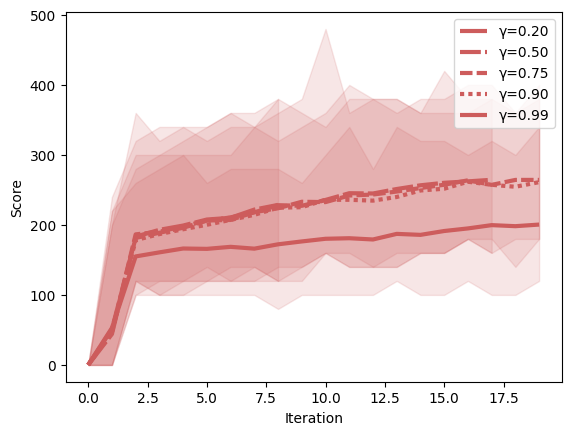

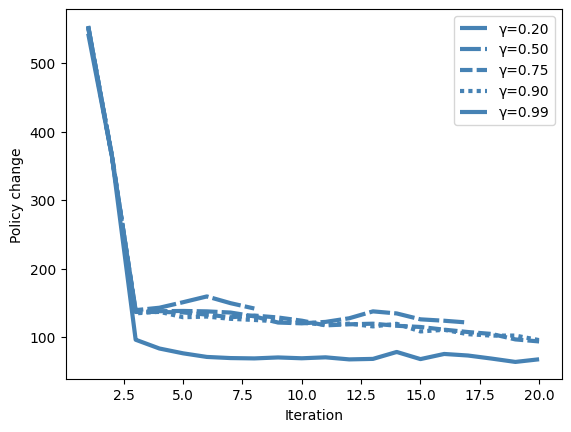

In [15]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20, reward_gradient_multiplier=0)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

{'γ=0.20': [((0.0, 0.0, 0.0), 0), ((0.0, 44.1, 220.0), 554.174160350336), ((100.0, 183.3, 300.0), 363.1652516417285), ((120.0, 193.0, 300.0), 139.21566003866087), ((120.0, 199.1, 320.0), 142.74452704044384), ((120.0, 207.7, 340.0), 150.821086058946), ((140.0, 210.2, 360.0), 159.245094115957), ((140.0, 221.9, 360.0), 149.38540758722053), ((120.0, 228.6, 380.0), 141.61214637170076)], 'γ=0.50': [((0.0, 0.0, 0.0), 0), ((0.0, 51.0, 240.0), 553.2684700938596), ((120.0, 181.4, 320.0), 364.13596361798704), ((120.0, 188.8, 340.0), 137.15319901482428), ((120.0, 195.9, 340.0), 137.6880532217665), ((140.0, 206.2, 320.0), 138.0507153186828), ((120.0, 210.7, 340.0), 137.43725841270262), ((120.0, 218.0, 340.0), 135.70556362949898), ((140.0, 228.2, 360.0), 130.18448448259878), ((140.0, 227.3, 380.0), 121.1156472137271), ((160.0, 235.7, 480.0), 119.9458211026962), ((140.0, 245.3, 360.0), 122.06555615733703), ((140.0, 244.9, 380.0), 127.37346662472527), ((160.0, 251.3, 380.0), 137.4445342674637), ((160.

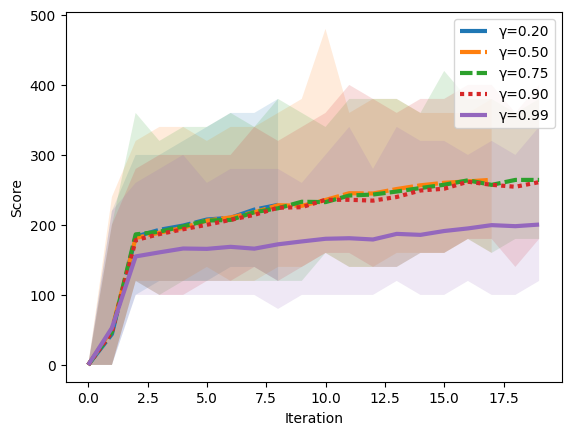

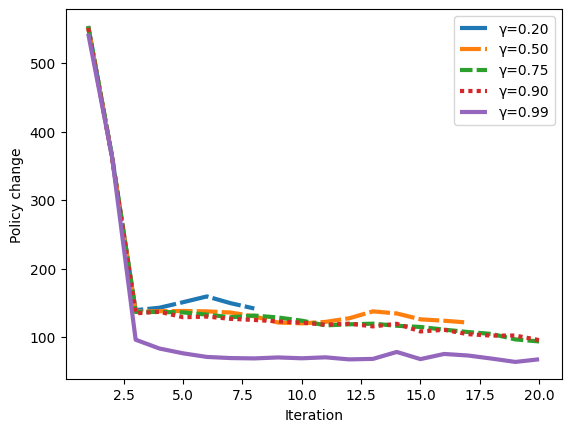

In [26]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
e = 0.001
max_iter = 50
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
print(records)
analysis_gama(records)

### 3. arm 2, alpha res 100, target resolution 10,  reward_gradient 1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1875.48it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1191.94it/s]


dleta = 25.0
perf = (9.344310221668458, 50.76211478386752, 192.08691703517)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 974.69it/s]


dleta = 5.0
perf = (171.8681024836907, 249.98595545503386, 332.41704839281755)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.73it/s]


dleta = 0.9999994880000003
perf = (151.80847085609204, 247.3006301086821, 352.16661057192005)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 929.41it/s]


dleta = 0.19999989760000003
perf = (151.8887393450865, 246.37206260947212, 392.2284086376493)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 927.83it/s]


dleta = 0.039999979520000006
perf = (171.95203815271682, 251.32065498264768, 392.17984620314104)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 889.69it/s]


dleta = 0.007999995903999996
perf = (131.7072766026243, 247.27923047931577, 432.13111092323396)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 915.33it/s]


dleta = 0.0015999991808000047
perf = (152.40862277594294, 246.6805076811765, 352.37296403960875)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.40it/s]


dleta = 0.0003199998361599968
perf = (171.538094587945, 248.27847636712676, 372.34272469962065)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1781.74it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1030.56it/s]


dleta = 40.0
perf = (9.344310221668458, 60.7216443462804, 192.1931617846398)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 837.55it/s]


dleta = 20.0
perf = (171.60098089622966, 253.78435292207914, 372.25038960815914)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 903.73it/s]


dleta = 9.980468749999998
perf = (171.53587886573573, 251.86507848549144, 352.4651975711355)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 902.13it/s]


dleta = 4.990234374999998
perf = (171.50207241744306, 256.6824421857281, 372.04296908933674)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 851.62it/s]


dleta = 2.495117187499999
perf = (151.89397791408203, 249.4750178755412, 372.1142020263338)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 895.29it/s]


dleta = 1.2475585937499998
perf = (151.68224101112074, 252.29803822930558, 352.48948185435233)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 892.74it/s]


dleta = 0.623779296875
perf = (171.62388190029736, 252.69269740807107, 392.11099662504364)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 930.39it/s]


dleta = 0.31188964843750006
perf = (171.716406312216, 254.4417922604515, 352.3199912514928)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.62it/s]


dleta = 0.15594482421875003
perf = (171.93527619775807, 250.78636066250783, 352.2739233867183)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 879.33it/s]


dleta = 0.07781982421874997
perf = (171.6024403336163, 254.6632594445415, 371.978524370859)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.80it/s]


dleta = 0.038909912109375
perf = (152.06985789036798, 248.3908078683625, 352.2825754246397)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 901.71it/s]


dleta = 0.0194549560546875
perf = (171.83227401992588, 257.27956641120926, 352.34926146992797)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 875.01it/s]


dleta = 0.00972747802734375
perf = (151.71800538398227, 252.88441655353068, 392.433998504032)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 936.05it/s]


dleta = 0.004863739013671875
perf = (171.69036704404334, 259.28504882922925, 372.46111190856027)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 912.73it/s]


dleta = 0.0024318695068359375
perf = (172.08040754917576, 250.86475435248417, 352.33690166600013)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 901.84it/s]


dleta = 0.0012159347534179688
perf = (171.85272180634007, 254.3695792428957, 371.9350652138973)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 928.95it/s]


dleta = 0.0006079673767089844
perf = (171.73875194904423, 254.7588977046442, 352.34263633239976)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1679.81it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1100.19it/s]


dleta = 79.99999999999997
perf = (9.344310221668458, 53.316440763344715, 171.84097986241483)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 893.35it/s]


dleta = 59.99999999999997
perf = (51.64789297790155, 235.04728988908536, 332.2623221849933)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 914.20it/s]


dleta = 36.990966796875
perf = (151.79024018649923, 237.7561805110701, 332.530421407194)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 935.57it/s]


dleta = 27.743225097656254
perf = (151.56399705038845, 240.81453810065773, 352.11610166673495)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 940.82it/s]


dleta = 20.807418823242188
perf = (172.2614478283923, 245.54258426860125, 352.12840403845547)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 916.30it/s]


dleta = 15.605564117431644
perf = (151.98470754786433, 244.26219466999467, 412.1474541378649)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 933.08it/s]


dleta = 11.704173088073734
perf = (151.78073801885284, 247.74008512497468, 351.9753522682952)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.62it/s]


dleta = 8.7781298160553
perf = (171.99099496332616, 248.93302003959715, 352.36164674977886)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 923.48it/s]


dleta = 6.583597362041476
perf = (151.97883681585677, 252.16954521238594, 372.2196921542979)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 846.92it/s]


dleta = 4.937698021531108
perf = (171.9816937051525, 255.15090655644408, 372.2473093230483)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 873.95it/s]


dleta = 3.7032735161483306
perf = (151.7759487420433, 256.9350321158839, 392.1912960784863)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 843.69it/s]


dleta = 2.777455137111248
perf = (172.21138977106094, 254.4480044873952, 352.38982463443756)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.68it/s]


dleta = 2.0830913528334363
perf = (171.6681607007133, 255.32041518478022, 372.07674109996753)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 911.67it/s]


dleta = 1.562318514625077
perf = (171.86481897199434, 256.43848342340203, 372.2018311946294)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 934.01it/s]


dleta = 1.171738885968808
perf = (171.97366998656236, 260.44392974773115, 392.02038344233125)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 909.98it/s]


dleta = 0.878804164476606
perf = (191.79723313180375, 259.82133078901404, 472.1382142006907)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 851.28it/s]


dleta = 0.6591031233574547
perf = (171.85667903450073, 260.1090836065837, 392.5008146478192)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 921.71it/s]


dleta = 0.4943273425180909
perf = (151.49045103099868, 262.02039379455056, 392.12376205670046)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 926.54it/s]


dleta = 0.3707455068885683
perf = (171.71918752717252, 258.3062324845649, 392.1297285435533)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.19it/s]


dleta = 0.27805913016642625
perf = (151.89355156406714, 262.7418387894739, 372.56539455690313)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 962.83it/s]


dleta = 0.20854434762481971
perf = (171.80823281329225, 262.21182205052327, 372.3233328330498)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.45it/s]


dleta = 0.15640826071861483
perf = (191.81711298090116, 265.01843782511054, 372.33509039871564)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.50it/s]


dleta = 0.11730619553896113
perf = (171.8289919401152, 260.1984359437901, 372.4861684341442)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 963.19it/s]


dleta = 0.08797964665422084
perf = (171.9289416387212, 266.71768870228584, 372.387978357054)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 928.54it/s]


dleta = 0.06598473499066562
perf = (191.59952383584104, 269.9209906639472, 392.4738795119789)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 942.40it/s]


dleta = 0.049488551242999224
perf = (191.76096893522396, 265.2984456508765, 412.12757034295026)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.69it/s]


dleta = 0.03711641343224942
perf = (171.86902277458222, 263.0879962650469, 372.1759961281456)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 959.48it/s]


dleta = 0.027837310074187077
perf = (171.53409622756692, 263.91791267342603, 391.96968107707534)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.69it/s]


dleta = 0.02087798255564033
perf = (171.81385273188639, 266.0114957283778, 372.3773355811734)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 945.28it/s]


dleta = 0.015658486916730274
perf = (171.54467616083576, 268.9093485316556, 372.4736084113968)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 952.06it/s]


dleta = 0.01174386518754772
perf = (171.97459428688592, 270.43010296460886, 372.1523778113726)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.64it/s]


dleta = 0.008807898890660804
perf = (171.82746947707463, 266.49434520097805, 352.45104168154086)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 907.77it/s]


dleta = 0.006605924167995603
perf = (191.5435637907919, 268.92764618498643, 392.34981278515943)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 910.49it/s]


dleta = 0.004954443125996688
perf = (171.77798862780838, 266.2140155599961, 452.1372940541906)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.62it/s]


dleta = 0.003715832344497516
perf = (171.56860739516483, 262.99439064724794, 372.439241560411)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 929.38it/s]


dleta = 0.002786874258373151
perf = (172.1612210935726, 264.51695464274655, 371.8287598897982)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 931.61it/s]


dleta = 0.002090155693779905
perf = (171.98504441984036, 263.03411672604926, 372.47155712647015)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 923.83it/s]


dleta = 0.0015676167703349564
perf = (171.45961785510158, 263.99940733534856, 392.29344453258784)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 922.00it/s]


dleta = 0.0011757125777512312
perf = (191.91198436029134, 273.0250438239219, 412.3131328509682)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.02it/s]


dleta = 0.0008817844333134373
perf = (191.65573894448326, 266.5179707623241, 392.1309065484234)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1852.18it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1099.26it/s]


dleta = 199.99999988570775
perf = (9.344310221668458, 64.38127077658216, 152.18818453413036)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 870.93it/s]


dleta = 179.99999987300862
perf = (111.33171234884472, 176.34041577784114, 292.28269392572935)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 910.05it/s]


dleta = 75.90655800000002
perf = (112.08767422100455, 182.4186090625405, 312.3485499240543)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 898.78it/s]


dleta = 68.31590220000001
perf = (111.64230683962431, 184.08740989974092, 331.7337766540471)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 907.94it/s]


dleta = 61.484311980000015
perf = (111.32271429063553, 191.63694831802505, 272.3447445351611)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 899.93it/s]


dleta = 55.33588078200001
perf = (131.47630276108154, 201.49630283379886, 312.00026688713007)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 912.46it/s]


dleta = 49.80229270380001
perf = (111.30711699355672, 198.44193732746027, 312.11319935129734)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 940.93it/s]


dleta = 44.82206343342001
perf = (131.46679356237973, 202.57788164350822, 292.56098027360514)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 972.59it/s]


dleta = 40.33985709007801
perf = (131.43395107980194, 202.0664975695385, 311.9146809998266)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.43it/s]


dleta = 36.30587138107022
perf = (131.20881434466918, 214.5798685401631, 332.5178334776076)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 955.55it/s]


dleta = 32.675284242963194
perf = (151.01296394936176, 217.27101106381065, 352.1289601786964)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.90it/s]


dleta = 29.407755818666885
perf = (151.13685102483313, 221.95487579556547, 352.05761507706103)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 951.31it/s]


dleta = 26.466980236800197
perf = (132.19710212312563, 224.31974567929444, 372.32451204643314)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 943.28it/s]


dleta = 23.82028221312018
perf = (151.51551649243316, 230.00452407744035, 332.2045526764366)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 968.49it/s]


dleta = 21.438253991808164
perf = (151.6102578743573, 236.5229044668153, 352.204615275497)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 975.01it/s]


dleta = 19.294428592627348
perf = (151.55212083957045, 239.91867335609805, 352.47809850828617)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 907.23it/s]


dleta = 17.364985733364612
perf = (151.5381307708484, 241.9095838316065, 372.3647317564223)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 881.09it/s]


dleta = 15.62848716002815
perf = (151.8112138485738, 244.72327428299505, 352.3296224082845)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 912.89it/s]


dleta = 14.065638444025335
perf = (151.52673838097618, 252.02611518492282, 372.09677295841436)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 922.88it/s]


dleta = 12.659074599622802
perf = (171.364148415742, 250.32590271582626, 352.454723542334)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.78it/s]


dleta = 11.393167139660521
perf = (171.35160271263408, 258.04045321934086, 412.166880641555)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 943.23it/s]


dleta = 10.25385042569447
perf = (171.45983822588633, 257.4609912110726, 352.12565478598054)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 918.16it/s]


dleta = 9.228465383125023
perf = (151.81239335306614, 258.4426306671274, 372.30650881219015)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.25it/s]


dleta = 8.305618844812523
perf = (171.7564036484885, 250.26205666292753, 352.20168891985395)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.52it/s]


dleta = 7.475056960331267
perf = (171.38910249968134, 257.5456957868298, 352.25796877197666)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.63it/s]


dleta = 6.72755126429814
perf = (151.4206255894016, 260.15650658291844, 371.99803093092993)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.20it/s]


dleta = 6.054796137868325
perf = (171.7701426644761, 261.1930260804188, 372.31326847663905)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.62it/s]


dleta = 5.31274713025418
perf = (171.39406588376661, 261.65725692247804, 372.3125519117186)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 918.65it/s]


dleta = 4.640813906115085
perf = (151.88951491441327, 262.36476028941956, 392.03280630944505)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 851.19it/s]


dleta = 4.036040715992672
perf = (171.4197869038983, 262.07945903692126, 372.32824851850273)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.07it/s]


dleta = 3.4917251054073137
perf = (171.56315909859788, 263.2580016208333, 392.19631103450376)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 915.48it/s]


dleta = 3.1247285805510874
perf = (191.70217001063713, 268.38720968292466, 352.3193316684016)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 904.88it/s]


dleta = 2.5606058136259637
perf = (171.85500915920414, 263.0761376869191, 352.11443272490743)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 907.53it/s]


dleta = 2.2779271352217374
perf = (171.7061401308985, 270.5983335206226, 372.2899979102569)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 874.30it/s]


dleta = 1.9421325152536582
perf = (191.68428210293848, 267.9068200804154, 352.1719475694026)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 931.07it/s]


dleta = 1.747732054883435
perf = (171.38423088474082, 267.3948604390663, 392.2165364310987)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 890.34it/s]


dleta = 1.5495033207009188
perf = (191.57448292919725, 265.78120865156194, 392.4556992998748)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.19it/s]


dleta = 1.3945529886308268
perf = (171.4622171645548, 264.47159325734685, 372.1858522159725)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 924.83it/s]


dleta = 1.2550976897677442
perf = (171.66563493384155, 263.7807459471359, 372.15744897511433)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 914.75it/s]


dleta = 1.0985755296148696
perf = (192.02052023079003, 265.8775140672048, 332.2863704542116)
Iteration #40


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 866.22it/s]


dleta = 0.9149662158406879
perf = (171.8997646954187, 268.38526978337165, 372.2769128545993)
Iteration #41


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 881.45it/s]


dleta = 0.7702839539075574
perf = (191.64759560090917, 265.08240788023335, 372.18955981464535)
Iteration #42


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.00it/s]


dleta = 0.6670103713478592
perf = (191.5880902130508, 263.97213550046246, 372.18219595282517)
Iteration #43


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 920.64it/s]


dleta = 0.5402784007917665
perf = (191.66519401201145, 270.09230701752773, 352.4448216000026)
Iteration #44


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.88it/s]


dleta = 0.48625056071258954
perf = (191.38394475506166, 269.4974909169348, 412.35609725788106)
Iteration #45


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 907.63it/s]


dleta = 0.3544766587594794
perf = (171.47269571694054, 267.5784485506103, 392.357842574669)
Iteration #46


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.65it/s]


dleta = 0.31902899288353015
perf = (191.48591730600654, 266.5739551134294, 352.57678838560554)
Iteration #47


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 905.18it/s]


dleta = 0.2473626269211029
perf = (191.67598249389786, 267.5848211061992, 372.3154257681099)
Iteration #48


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 931.63it/s]


dleta = 0.18838343000779645
perf = (171.81608560575717, 264.985873336711, 392.16018703266263)
Iteration #49


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 868.97it/s]


dleta = 0.16954508700701676
perf = (191.79857845491728, 265.8751937522474, 411.96959636025457)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1825.39it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1041.91it/s]


dleta = 1739.068447776226
perf = (9.307039055672952, 66.24240683180858, 192.00930014724528)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 897.19it/s]


dleta = 1716.4327755315414
perf = (111.51592537675141, 158.93286736888354, 232.22340134456059)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 911.39it/s]


dleta = 334.41218489999846
perf = (92.18934099483266, 166.14820255713, 292.3194074843511)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 914.14it/s]


dleta = 89.85718971295569
perf = (112.00277295013976, 169.5992679847439, 292.48591391547257)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 888.42it/s]


dleta = 87.93755160692021
perf = (111.4491185769898, 170.11913117877413, 332.3119699295435)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 916.73it/s]


dleta = 81.81861251824029
perf = (111.46943739061795, 174.02107023698528, 292.17922149365876)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 924.93it/s]


dleta = 79.09917474482549
perf = (91.03569532293092, 175.5374573058645, 332.11302666833853)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 921.60it/s]


dleta = 76.86653994512895
perf = (111.17433269298553, 176.85335782080116, 252.33317616508418)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 904.02it/s]


dleta = 74.58352684221865
perf = (111.59645796700573, 180.03221630185104, 272.05531613458515)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 866.82it/s]


dleta = 73.0993146580584
perf = (91.19095346824979, 177.8949247859214, 291.9259194321765)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 872.19it/s]


dleta = 70.27441281766608
perf = (111.4760896335754, 182.051070432939, 272.61063430316136)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 860.98it/s]


dleta = 64.25332744560774
perf = (91.37028272787043, 183.05898685304746, 252.74201408259344)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 896.13it/s]


dleta = 63.61079417115167
perf = (111.80057912680522, 187.44237446547336, 312.1602903400003)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.54it/s]


dleta = 60.243646085774
perf = (91.37460979167416, 184.7011821612029, 292.3460492076738)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.47it/s]


dleta = 58.6409442319374
perf = (111.50223732926926, 193.23355696851732, 292.1797472524179)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.83it/s]


dleta = 57.47398944172198
perf = (111.59923345914837, 189.69114960974468, 332.39549693094335)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 870.64it/s]


dleta = 56.132200491640845
perf = (131.47296308571987, 194.92285887609384, 272.4874082804073)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.46it/s]


dleta = 55.033609750654705
perf = (111.49998679787343, 195.7001777057676, 292.57246688418587)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 906.16it/s]


dleta = 53.58176876518729
perf = (131.48471129818256, 199.0939711626742, 332.3947453737642)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 913.03it/s]


dleta = 52.318878980026284
perf = (111.43376665037695, 199.32270335065073, 292.5372976638219)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.72it/s]


dleta = 50.955728951735864
perf = (131.30010363603859, 199.49453121595963, 292.15609884244225)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 943.59it/s]


dleta = 49.94170994559636
perf = (131.45895506885245, 204.7982328837302, 332.4045133596619)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 947.65it/s]


dleta = 48.45839121850213
perf = (131.59043250502478, 206.58886476522414, 292.4016131761064)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 929.51it/s]


dleta = 47.9738073063171
perf = (131.4408428088517, 202.6125652463428, 332.0092595283236)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 904.41it/s]


dleta = 47.019128540921315
perf = (111.93968562333049, 207.08448212065235, 352.0793130004197)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 912.26it/s]


dleta = 45.622613404127264
perf = (131.73343615255382, 208.1872023243599, 312.1118942425385)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 929.01it/s]


dleta = 44.71472339738534
perf = (131.3488566266177, 209.9805855258811, 352.131260112474)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 931.78it/s]


dleta = 43.38665139775969
perf = (151.37574678287478, 218.82147226957787, 351.824685111205)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 812.70it/s]


dleta = 42.9527848837821
perf = (131.1332750035041, 213.50032284552847, 332.2059312506901)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 896.11it/s]


dleta = 41.677044219948925
perf = (131.51644853318638, 213.51131326799322, 332.1129036604111)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 921.11it/s]


dleta = 40.8476710399716
perf = (131.4981170549883, 218.42692617510386, 352.45228370770354)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 948.92it/s]


dleta = 40.0348023862764
perf = (131.53659397765534, 221.58895381129983, 372.21940133414483)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.27it/s]


dleta = 38.88480346796621
perf = (151.3871944061285, 224.69657916798863, 351.61040909220696)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.51it/s]


dleta = 38.072698719061464
perf = (151.5529973569734, 222.28532545854327, 331.77937299958734)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 920.94it/s]


dleta = 37.31505201455229
perf = (111.80671661487973, 223.10163269012372, 351.91003712730617)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 969.82it/s]


dleta = 36.57248247946268
perf = (151.21539320757748, 224.78704623985539, 312.3018239250671)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 914.96it/s]


dleta = 35.48624317734027
perf = (151.41418145268796, 230.729877082947, 412.28486169247543)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 927.40it/s]


dleta = 34.78006693811142
perf = (151.74387097570192, 232.80568809552278, 352.35733478095995)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 954.54it/s]


dleta = 33.747064169982195
perf = (151.72102564693358, 230.29977832395267, 372.0466404639017)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 952.84it/s]


dleta = 33.07549759299957
perf = (131.8706401663822, 229.5042216536048, 352.392808066691)
Iteration #40


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 893.95it/s]


dleta = 32.093122238989736
perf = (151.4507137700898, 232.20005418043374, 332.56576161469735)
Iteration #41


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 864.84it/s]


dleta = 31.454469106434544
perf = (151.44907443054328, 233.404547834283, 332.2996733430044)
Iteration #42


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 916.76it/s]


dleta = 30.520239919504093
perf = (151.5343580156388, 243.02073134947034, 352.4149541961827)
Iteration #43


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 869.86it/s]


dleta = 29.912887145106197
perf = (151.4646019016, 239.19858324402747, 372.0538791116655)
Iteration #44


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 958.43it/s]


dleta = 29.024444484008768
perf = (151.74314297008473, 239.03273002155228, 352.2057618200293)
Iteration #45


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 857.95it/s]


dleta = 28.44685803877735
perf = (151.36877602124636, 238.51008071030745, 372.3896412987338)
Iteration #46


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 931.94it/s]


dleta = 27.60195790816772
perf = (151.66711652185646, 240.11521471860902, 372.2871455528407)
Iteration #47


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 911.62it/s]


dleta = 27.052678945794696
perf = (171.71368653853304, 243.32125411647547, 352.5493461478893)
Iteration #48


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 947.88it/s]


dleta = 26.24918732842582
perf = (151.3935216443179, 239.10353706210418, 372.3362581291155)
Iteration #49


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 943.58it/s]


dleta = 25.726828500590386
perf = (151.47977678076256, 245.2040804809022, 412.24202341657593)


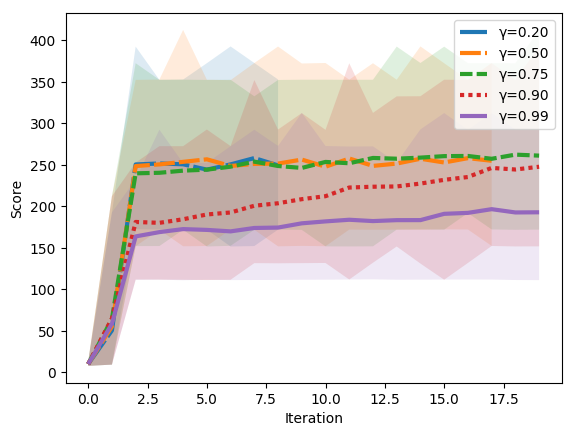

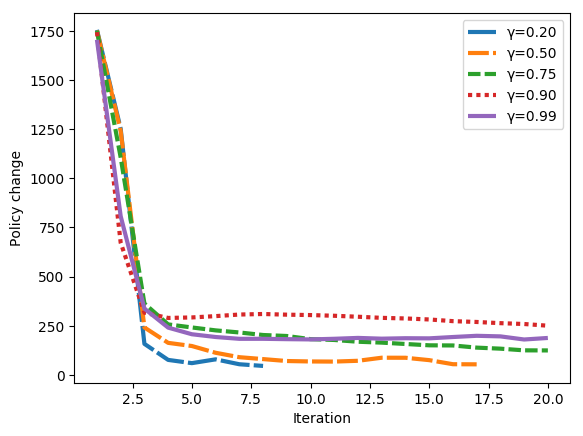

In [10]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 100
x_res = 10
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, 
                   reward_reach=20, reward_gradient_multiplier=1)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

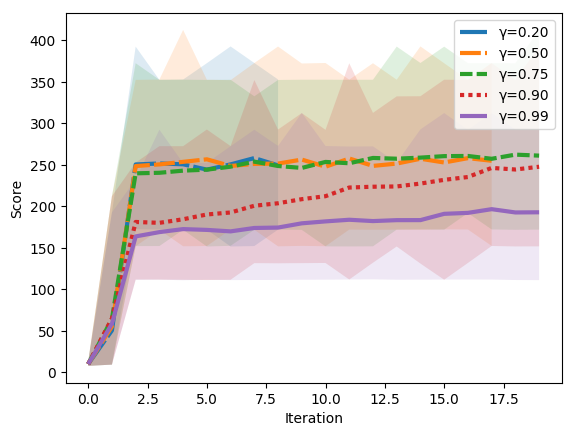

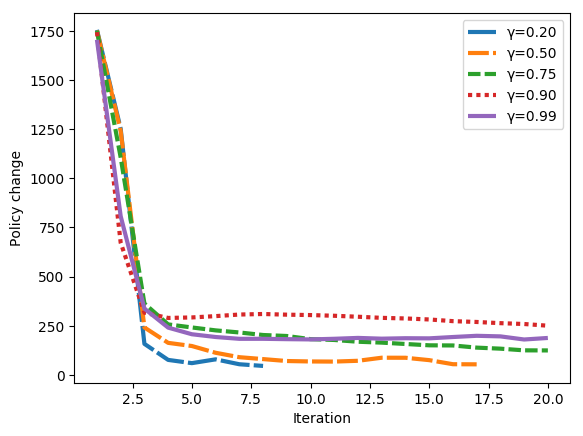

In [11]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 100
x_res = 10
e = 0.001
max_iter = 50
filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis_gama(records)

### 4. arm 2, alpha res 100, target resolution 10,  reward_gradient 0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1659.09it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1299.63it/s]


dleta = 25.0
perf = (0.0, 34.3, 180.0)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 930.97it/s]


dleta = 5.0
perf = (100.0, 166.5, 300.0)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 913.66it/s]


dleta = 0.9999994880000003
perf = (100.0, 173.6, 320.0)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.62it/s]


dleta = 0.19999989760000003
perf = (120.0, 176.3, 260.0)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 899.65it/s]


dleta = 0.039999979520000006
perf = (120.0, 186.0, 280.0)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 905.24it/s]


dleta = 0.007999995904000003
perf = (120.0, 184.1, 300.0)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 827.81it/s]


dleta = 0.0015999991808000004
perf = (120.0, 180.8, 280.0)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 897.10it/s]


dleta = 0.00031999983616000003
perf = (120.0, 193.8, 320.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1761.88it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1250.38it/s]


dleta = 40.0
perf = (0.0, 41.3, 220.0)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 940.69it/s]


dleta = 20.0
perf = (100.0, 168.3, 280.0)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 905.41it/s]


dleta = 9.98046875
perf = (100.0, 171.3, 260.0)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 865.31it/s]


dleta = 4.990234375
perf = (120.0, 175.1, 300.0)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 811.70it/s]


dleta = 2.4951171875
perf = (120.0, 179.8, 320.0)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.80it/s]


dleta = 1.24755859375
perf = (120.0, 187.7, 280.0)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 896.53it/s]


dleta = 0.623779296875
perf = (120.0, 188.8, 300.0)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.87it/s]


dleta = 0.3118896484375
perf = (120.0, 193.1, 300.0)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 969.35it/s]


dleta = 0.15594482421875
perf = (100.0, 197.5, 340.0)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.51it/s]


dleta = 0.07781982421875
perf = (100.0, 198.4, 300.0)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 896.18it/s]


dleta = 0.038909912109375
perf = (100.0, 206.2, 300.0)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 941.52it/s]


dleta = 0.0194549560546875
perf = (120.0, 208.8, 300.0)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 948.62it/s]


dleta = 0.00972747802734375
perf = (120.0, 208.6, 360.0)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.29it/s]


dleta = 0.004863739013671875
perf = (140.0, 217.2, 340.0)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.19it/s]


dleta = 0.0024318695068359375
perf = (140.0, 222.4, 360.0)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 920.66it/s]


dleta = 0.0012159347534179688
perf = (140.0, 228.6, 320.0)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 934.98it/s]


dleta = 0.0006079673767089844
perf = (140.0, 225.1, 340.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1694.37it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1273.53it/s]


dleta = 79.99999999999997
perf = (0.0, 38.9, 220.0)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 933.45it/s]


dleta = 59.99999999999997
perf = (100.0, 168.1, 260.0)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.94it/s]


dleta = 36.990966796875
perf = (100.0, 168.4, 280.0)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.40it/s]


dleta = 27.74322509765625
perf = (100.0, 173.0, 280.0)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.36it/s]


dleta = 20.807418823242188
perf = (120.0, 177.0, 260.0)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 866.85it/s]


dleta = 15.60556411743164
perf = (120.0, 186.6, 280.0)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 805.24it/s]


dleta = 11.70417308807373
perf = (100.0, 189.3, 300.0)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 887.22it/s]


dleta = 8.778129816055298
perf = (120.0, 192.0, 360.0)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 843.35it/s]


dleta = 6.583597362041473
perf = (120.0, 202.1, 300.0)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 906.32it/s]


dleta = 4.937698021531105
perf = (120.0, 201.8, 300.0)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 906.26it/s]


dleta = 3.703273516148329
perf = (120.0, 203.1, 420.0)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 878.51it/s]


dleta = 2.7774551371112466
perf = (100.0, 207.0, 340.0)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 904.37it/s]


dleta = 2.083091352833435
perf = (120.0, 211.0, 340.0)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 864.00it/s]


dleta = 1.5623185146250762
perf = (140.0, 214.7, 320.0)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 885.49it/s]


dleta = 1.1717388859688072
perf = (120.0, 213.1, 360.0)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.89it/s]


dleta = 0.8788041644766054
perf = (120.0, 223.7, 320.0)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 869.71it/s]


dleta = 0.659103123357454
perf = (140.0, 224.1, 320.0)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 903.39it/s]


dleta = 0.4943273425180905
perf = (120.0, 229.7, 360.0)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 944.13it/s]


dleta = 0.3707455068885679
perf = (140.0, 231.8, 360.0)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 921.42it/s]


dleta = 0.2780591301664259
perf = (140.0, 231.3, 340.0)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 941.54it/s]


dleta = 0.20854434762481944
perf = (160.0, 236.0, 340.0)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 923.97it/s]


dleta = 0.15640826071861458
perf = (140.0, 239.6, 340.0)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 930.67it/s]


dleta = 0.11730619553896093
perf = (160.0, 239.9, 360.0)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.16it/s]


dleta = 0.0879796466542207
perf = (140.0, 244.9, 320.0)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 920.04it/s]


dleta = 0.06598473499066553
perf = (160.0, 247.8, 360.0)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 878.57it/s]


dleta = 0.04948855124299914
perf = (160.0, 242.7, 360.0)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 912.05it/s]


dleta = 0.037116413432249355
perf = (180.0, 248.8, 400.0)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 909.24it/s]


dleta = 0.027837310074187015
perf = (160.0, 248.7, 360.0)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 918.82it/s]


dleta = 0.02087798255564026
perf = (160.0, 250.7, 380.0)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 905.81it/s]


dleta = 0.015658486916730194
perf = (160.0, 248.2, 380.0)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 880.38it/s]


dleta = 0.011743865187547647
perf = (180.0, 249.8, 340.0)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 918.29it/s]


dleta = 0.008807898890660734
perf = (160.0, 257.7, 360.0)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.23it/s]


dleta = 0.0066059241679955515
perf = (180.0, 257.5, 360.0)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 914.26it/s]


dleta = 0.004954443125996664
perf = (160.0, 254.1, 360.0)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 833.25it/s]


dleta = 0.003715832344497498
perf = (160.0, 253.4, 380.0)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 902.61it/s]


dleta = 0.0027868742583731236
perf = (160.0, 258.6, 360.0)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 919.75it/s]


dleta = 0.0020901556937798424
perf = (160.0, 250.9, 360.0)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 881.74it/s]


dleta = 0.0015676167703348818
perf = (160.0, 255.0, 380.0)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 897.87it/s]


dleta = 0.0011757125777511616
perf = (180.0, 253.4, 360.0)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 886.06it/s]


dleta = 0.0008817844333133711
perf = (180.0, 254.8, 380.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1640.61it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1212.47it/s]


dleta = 199.99999988570775
perf = (0.0, 42.2, 200.0)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 963.38it/s]


dleta = 179.99999987300862
perf = (100.0, 166.3, 240.0)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 960.29it/s]


dleta = 75.906558
perf = (100.0, 171.3, 280.0)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.23it/s]


dleta = 68.3159022
perf = (120.0, 175.5, 280.0)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.65it/s]


dleta = 61.48431198
perf = (100.0, 178.2, 300.0)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 909.03it/s]


dleta = 55.335880782000004
perf = (100.0, 183.9, 280.0)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 883.77it/s]


dleta = 49.8022927038
perf = (120.0, 190.5, 320.0)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 904.53it/s]


dleta = 44.82206343342
perf = (120.0, 187.4, 300.0)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 889.67it/s]


dleta = 40.339857090078
perf = (120.0, 200.7, 320.0)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.17it/s]


dleta = 36.3058713810702
perf = (120.0, 199.9, 300.0)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 930.07it/s]


dleta = 32.67528424296318
perf = (120.0, 203.7, 320.0)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 938.01it/s]


dleta = 29.407755818666864
perf = (120.0, 208.0, 300.0)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.35it/s]


dleta = 26.46698023680018
perf = (120.0, 213.8, 340.0)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 786.98it/s]


dleta = 23.820282213120162
perf = (120.0, 213.5, 300.0)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 905.67it/s]


dleta = 21.438253991808146
perf = (120.0, 217.4, 360.0)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 920.34it/s]


dleta = 19.29442859262733
perf = (140.0, 221.5, 360.0)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 902.95it/s]


dleta = 17.3649857333646
perf = (120.0, 223.2, 360.0)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 869.55it/s]


dleta = 15.628487160028142
perf = (120.0, 225.5, 340.0)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.28it/s]


dleta = 14.065638444025328
perf = (140.0, 233.2, 320.0)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 899.44it/s]


dleta = 12.659074599622796
perf = (160.0, 232.8, 380.0)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 921.84it/s]


dleta = 11.393167139660518
perf = (140.0, 235.8, 340.0)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 955.71it/s]


dleta = 10.253850425694466
perf = (160.0, 237.0, 360.0)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 954.01it/s]


dleta = 9.22846538312502
perf = (140.0, 239.2, 360.0)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 961.12it/s]


dleta = 8.305618844812516
perf = (160.0, 239.6, 360.0)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 928.79it/s]


dleta = 7.4750569603312655
perf = (160.0, 241.6, 380.0)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 959.35it/s]


dleta = 6.727551264298139
perf = (160.0, 249.9, 380.0)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 938.35it/s]


dleta = 6.054796137868325
perf = (160.0, 243.3, 340.0)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 951.98it/s]


dleta = 5.327613410809368
perf = (160.0, 247.8, 380.0)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 959.27it/s]


dleta = 4.65345647289939
perf = (160.0, 247.4, 380.0)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 852.50it/s]


dleta = 4.046716118458658
perf = (180.0, 253.3, 360.0)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 930.23it/s]


dleta = 3.500650383179898
perf = (160.0, 249.4, 380.0)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 917.70it/s]


dleta = 3.1247285805510825
perf = (180.0, 248.1, 380.0)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 885.49it/s]


dleta = 2.5668796307109085
perf = (180.0, 257.6, 360.0)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 929.27it/s]


dleta = 2.27792713522174
perf = (160.0, 254.0, 360.0)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 872.54it/s]


dleta = 1.9491714794361996
perf = (160.0, 258.6, 380.0)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 927.86it/s]


dleta = 1.7542543314925798
perf = (160.0, 248.7, 360.0)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 940.29it/s]


dleta = 1.5495033207009172
perf = (160.0, 257.0, 340.0)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 900.66it/s]


dleta = 1.3945529886308257
perf = (180.0, 253.1, 400.0)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 936.11it/s]


dleta = 1.255097689767743
perf = (180.0, 260.0, 360.0)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 834.55it/s]


dleta = 1.1295879207909687
perf = (160.0, 255.5, 380.0)
Iteration #40


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 956.31it/s]


dleta = 0.9149662158406848
perf = (180.0, 252.8, 380.0)
Iteration #41


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 915.17it/s]


dleta = 0.8220918917584977
perf = (180.0, 257.0, 360.0)
Iteration #42


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 893.21it/s]


dleta = 0.6670103713478597
perf = (180.0, 256.0, 360.0)
Iteration #43


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 886.67it/s]


dleta = 0.5402784007917656
perf = (180.0, 259.1, 400.0)
Iteration #44


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 852.99it/s]


dleta = 0.4862505607125891
perf = (180.0, 259.4, 360.0)
Iteration #45


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 928.46it/s]


dleta = 0.37054553318759575
perf = (180.0, 256.0, 360.0)
Iteration #46


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 952.38it/s]


dleta = 0.31902899288352904
perf = (180.0, 252.8, 360.0)
Iteration #47


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 949.61it/s]


dleta = 0.2481157864160881
perf = (160.0, 253.7, 360.0)
Iteration #48


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 915.51it/s]


dleta = 0.18838343000779711
perf = (160.0, 256.3, 360.0)
Iteration #49


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 937.68it/s]


dleta = 0.16954508700701743
perf = (160.0, 252.8, 400.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1785.64it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1227.97it/s]


dleta = 1738.7435936170846
perf = (0.0, 48.9, 220.0)
Iteration #1


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 949.87it/s]


dleta = 1716.1046400172572
perf = (100.0, 154.9, 220.0)
Iteration #2


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.67it/s]


dleta = 334.8285208632295
perf = (100.0, 157.5, 280.0)
Iteration #3


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 962.23it/s]


dleta = 89.13176907589843
perf = (100.0, 155.7, 240.0)
Iteration #4


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 958.06it/s]


dleta = 87.22139378411313
perf = (80.0, 160.4, 240.0)
Iteration #5


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.76it/s]


dleta = 81.11022169342846
perf = (100.0, 162.1, 260.0)
Iteration #6


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 952.54it/s]


dleta = 78.93114067835708
perf = (100.0, 162.2, 300.0)
Iteration #7


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 867.38it/s]


dleta = 76.8980184645072
perf = (100.0, 165.6, 260.0)
Iteration #8


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 975.57it/s]


dleta = 74.61407041809292
perf = (80.0, 167.7, 260.0)
Iteration #9


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.28it/s]


dleta = 73.12925041677289
perf = (100.0, 167.4, 280.0)
Iteration #10


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 956.72it/s]


dleta = 70.13076676741952
perf = (100.0, 168.2, 260.0)
Iteration #11


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 925.26it/s]


dleta = 64.3380566007126
perf = (120.0, 171.1, 260.0)
Iteration #12


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.90it/s]


dleta = 63.694676034705424
perf = (120.0, 171.9, 300.0)
Iteration #13


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 941.19it/s]


dleta = 60.36057897415708
perf = (100.0, 177.5, 280.0)
Iteration #14


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 886.85it/s]


dleta = 58.74212727239478
perf = (120.0, 172.1, 260.0)
Iteration #15


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 954.26it/s]


dleta = 57.573158939674215
perf = (100.0, 177.6, 280.0)
Iteration #16


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 973.32it/s]


dleta = 56.242253595210286
perf = (120.0, 182.1, 280.0)
Iteration #17


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 996.92it/s]


dleta = 55.1404299609909
perf = (100.0, 187.5, 280.0)
Iteration #18


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 975.40it/s]


dleta = 53.68874002204279
perf = (120.0, 185.1, 300.0)
Iteration #19


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 926.12it/s]


dleta = 52.421455664293035
perf = (100.0, 188.7, 340.0)
Iteration #20


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 938.06it/s]


dleta = 51.05745755263092
perf = (120.0, 184.3, 280.0)
Iteration #21


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 957.20it/s]


dleta = 50.0414141473334
perf = (120.0, 190.7, 280.0)
Iteration #22


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 958.36it/s]


dleta = 48.55513410574315
perf = (120.0, 195.1, 320.0)
Iteration #23


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 974.66it/s]


dleta = 48.06958276468572
perf = (120.0, 195.3, 300.0)
Iteration #24


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.17it/s]


dleta = 47.00981760741183
perf = (120.0, 194.8, 320.0)
Iteration #25


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 963.31it/s]


dleta = 45.71369491206087
perf = (120.0, 197.0, 320.0)
Iteration #26


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 941.59it/s]


dleta = 44.80399238331108
perf = (100.0, 198.1, 300.0)
Iteration #27


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 945.96it/s]


dleta = 43.47326900553446
perf = (120.0, 206.8, 320.0)
Iteration #28


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 865.47it/s]


dleta = 43.03853631547918
perf = (120.0, 204.6, 300.0)
Iteration #29


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 877.33it/s]


dleta = 41.76024874837299
perf = (100.0, 202.2, 300.0)
Iteration #30


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 959.19it/s]


dleta = 40.92921979827997
perf = (120.0, 211.1, 360.0)
Iteration #31


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 945.35it/s]


dleta = 40.11472832429445
perf = (140.0, 205.9, 340.0)
Iteration #32


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 954.05it/s]


dleta = 38.96358065413801
perf = (120.0, 208.6, 340.0)
Iteration #33


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 946.10it/s]


dleta = 38.14870749084571
perf = (120.0, 211.8, 340.0)
Iteration #34


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 893.64it/s]


dleta = 37.38954821177765
perf = (120.0, 212.6, 300.0)
Iteration #35


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 953.35it/s]


dleta = 36.64549620236323
perf = (140.0, 215.8, 360.0)
Iteration #36


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 829.85it/s]


dleta = 35.55708831965728
perf = (140.0, 218.4, 340.0)
Iteration #37


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 838.84it/s]


dleta = 34.84950226209605
perf = (140.0, 216.5, 340.0)
Iteration #38


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 934.73it/s]


dleta = 33.81443719540903
perf = (140.0, 221.4, 320.0)
Iteration #39


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 932.60it/s]


dleta = 33.14152989522097
perf = (140.0, 221.8, 340.0)
Iteration #40


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 940.53it/s]


dleta = 32.157193315803056
perf = (140.0, 220.2, 340.0)
Iteration #41


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 947.35it/s]


dleta = 31.5172651688182
perf = (140.0, 220.9, 320.0)
Iteration #42


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 964.01it/s]


dleta = 30.581170876039096
perf = (140.0, 226.0, 340.0)
Iteration #43


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 970.80it/s]


dleta = 29.97260557560594
perf = (140.0, 224.2, 320.0)
Iteration #44


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 957.66it/s]


dleta = 29.08238921740508
perf = (160.0, 230.8, 340.0)
Iteration #45


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 939.57it/s]


dleta = 28.503649671978792
perf = (160.0, 226.4, 340.0)
Iteration #46


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 846.37it/s]


dleta = 27.65706277307106
perf = (140.0, 226.1, 340.0)
Iteration #47


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 926.89it/s]


dleta = 27.106687223886752
perf = (140.0, 228.1, 360.0)
Iteration #48


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 945.26it/s]


dleta = 26.30159150665054
perf = (140.0, 230.5, 380.0)
Iteration #49


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 950.03it/s]


dleta = 25.778189835667945
perf = (140.0, 235.4, 360.0)


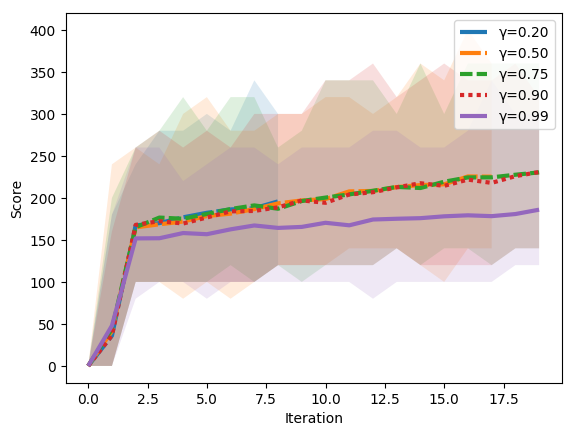

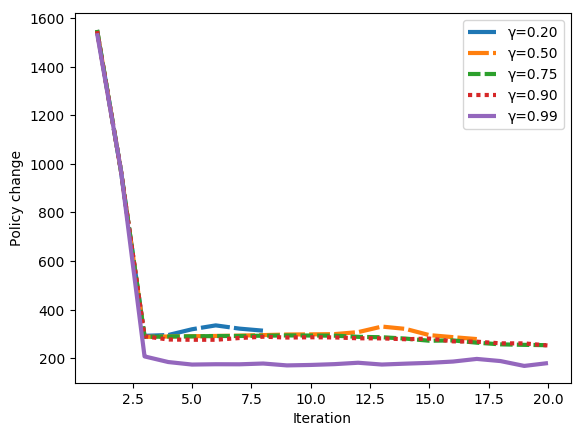

In [12]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 100
x_res = 10
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res,
                   reward_reach=20, reward_gradient_multiplier=0)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

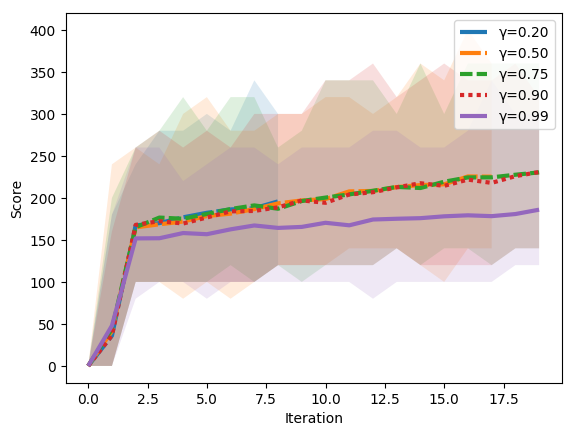

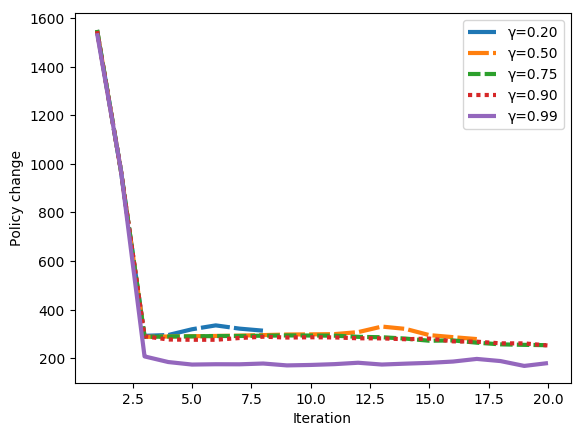

In [13]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 100
x_res = 10
e = 0.001
max_iter = 50
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis_gama(records)

### 5. arm 3, alpha res 20, target resolution 10,  reward_gradient 1


0.2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5409.63it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2850.66it/s]


dleta = 24.999999999999947
perf = (2.032170772537102, 18.02799457690054, 122.13519572240516)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2651.13it/s]


dleta = 4.999999999999947
perf = (2.800045792219025, 29.44081424109994, 162.33048537303299)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2883.52it/s]


dleta = 0.9999360000000008
perf = (2.823098741943231, 28.164482611262432, 162.158740185234)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2817.39it/s]


dleta = 0.19998720000000014
perf = (2.800045792219025, 27.357417893188835, 142.35781092064184)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2785.41it/s]


dleta = 0.039987200000000084
perf = (2.800045792219025, 31.03467678305203, 162.3862084134658)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3081.24it/s]


dleta = 0.007997440000000022
perf = (2.800045792219025, 23.277965111984155, 162.2717275598343)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2919.35it/s]


dleta = 0.00159948800000001
perf = (2.800045792219025, 31.44357284522627, 142.3426433408244)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2661.20it/s]


dleta = 0.0003198976000000006
perf = (2.800045792219025, 30.040265309215002, 182.12299308962938)
0.5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5669.89it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2698.30it/s]


dleta = 39.99998092651367
perf = (1.9683001582254611, 21.58128610540734, 202.06268399465756)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2804.60it/s]


dleta = 19.999980926513672
perf = (2.799257776629266, 27.33912113614786, 182.16056500283804)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2361.29it/s]


dleta = 9.84375
perf = (2.823098741943231, 26.958391341562283, 162.3952634798603)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2400.15it/s]


dleta = 4.921875
perf = (2.823098741943231, 28.44935839905984, 182.23033181281812)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2776.49it/s]


dleta = 2.4605600877796965
perf = (2.800045792219025, 26.75732088719712, 162.20755137852143)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2693.96it/s]


dleta = 1.2300237304922663
perf = (2.800045792219025, 30.340520423336958, 202.07817245976472)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2777.45it/s]


dleta = 0.615011865246133
perf = (2.800045792219025, 28.34467559954546, 182.06846374786153)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2687.18it/s]


dleta = 0.30750593262306647
perf = (2.800045792219025, 30.64651869763328, 261.9460345806759)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2476.32it/s]


dleta = 0.1537529663115332
perf = (2.800045792219025, 32.6295664458774, 202.15818224699936)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2506.13it/s]


dleta = 0.06835937500000011
perf = (2.800045792219025, 27.35892876099177, 202.08840146960543)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2752.22it/s]


dleta = 0.029296875000000056
perf = (2.800045792219025, 30.952754688275103, 242.03363742294073)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2671.94it/s]


dleta = 0.009765625
perf = (2.800045792219025, 28.655343463143915, 182.1462223936326)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2885.05it/s]


dleta = 0.0048828125
perf = (2.800045792219025, 30.545967627295703, 202.1178968988627)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2666.62it/s]


dleta = 0.00244140625
perf = (2.800045792219025, 32.5338616576712, 202.23573769110197)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2812.50it/s]


dleta = 0.001220703125
perf = (2.800045792219025, 31.842359922045297, 202.10360770808083)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2735.67it/s]


dleta = 0.0006103515625
perf = (2.800045792219025, 26.556775908785912, 162.11069416612756)
0.75


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5456.36it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2684.39it/s]


dleta = 79.80972728366396
perf = (1.9683001582254611, 17.63494005067098, 122.14225841823333)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2712.54it/s]


dleta = 59.80972728366396
perf = (2.7163277363719693, 36.478782147732005, 182.14010043852497)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2822.62it/s]


dleta = 34.3212890625
perf = (2.7997959358864417, 30.2273441499424, 182.25615033515987)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2434.00it/s]


dleta = 25.740966796875
perf = (2.7997959358864417, 35.81750137425273, 182.22626637336947)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2833.58it/s]


dleta = 19.30572509765625
perf = (2.7997959358864417, 29.74207203895469, 202.02071582084614)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2790.00it/s]


dleta = 14.479293823242188
perf = (2.7997959358864417, 30.549880328331948, 182.07680257717686)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2799.41it/s]


dleta = 10.859470367431644
perf = (2.7997959358864417, 32.337487560484, 202.09651750651426)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2701.01it/s]


dleta = 7.299900054931641
perf = (2.800045792219025, 33.83181398645834, 202.04356663135135)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2846.61it/s]


dleta = 4.630222320556644
perf = (2.800045792219025, 31.641928630026495, 162.10128900089578)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2928.51it/s]


dleta = 2.6279640197753933
perf = (2.800045792219025, 30.94907945976643, 202.1698216914632)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2964.75it/s]


dleta = 1.720025083071052
perf = (2.800045792219025, 28.557541942383267, 262.049669042793)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2778.77it/s]


dleta = 1.0987734608352184
perf = (2.800045792219025, 31.14722302366438, 202.04570616180706)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2880.24it/s]


dleta = 0.6335270404815718
perf = (2.800045792219025, 29.65648596393745, 162.22308643912777)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2740.78it/s]


dleta = 0.47514528036118264
perf = (2.823098741943231, 34.82899254216046, 202.0494499725174)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2925.37it/s]


dleta = 0.35635896027088876
perf = (2.800045792219025, 28.854850898446497, 142.32890446142727)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2989.72it/s]


dleta = 0.26726922020316835
perf = (2.800045792219025, 33.14151105988688, 162.2084318259884)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2784.91it/s]


dleta = 0.20045191515237626
perf = (2.800045792219025, 32.14573619702409, 202.1258713568351)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2791.35it/s]


dleta = 0.15033893636428175
perf = (2.800045792219025, 31.74544599889964, 242.01924297764953)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3020.46it/s]


dleta = 0.1127542022732122
perf = (2.800045792219025, 29.35605729494896, 202.14004490982884)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2829.19it/s]


dleta = 0.08456565170490649
perf = (2.823098741943231, 33.14238705273834, 202.1531030521642)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2481.31it/s]


dleta = 0.06342423877867986
perf = (2.800045792219025, 26.065582657044935, 182.12293322868564)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2720.82it/s]


dleta = 0.04756817908401079
perf = (2.800045792219025, 29.360559018649397, 202.22646690954048)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2748.21it/s]


dleta = 0.0356761343130092
perf = (2.800045792219025, 31.849928684454408, 202.11309381975985)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2863.73it/s]


dleta = 0.026757100734757344
perf = (2.823098741943231, 31.042092879897154, 182.11538757091233)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2678.78it/s]


dleta = 0.020067825551066676
perf = (2.800045792219025, 31.546134341964176, 222.0825257162456)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2856.06it/s]


dleta = 0.01505086916330356
perf = (2.800045792219025, 30.94422610186296, 162.17626834781404)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.70it/s]


dleta = 0.01128815187247767
perf = (2.800045792219025, 31.143710146430866, 162.356499513599)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2950.32it/s]


dleta = 0.008466113904361805
perf = (2.800045792219025, 27.95612815657561, 182.27483450078495)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2853.36it/s]


dleta = 0.0063495854282749065
perf = (2.800045792219025, 29.458228521528216, 142.28179735826689)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3001.85it/s]


dleta = 0.004762189071207956
perf = (2.800045792219025, 31.044609783429046, 182.21827195115597)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2964.55it/s]


dleta = 0.0035716418034077435
perf = (2.800045792219025, 35.23494065623434, 222.05007593377144)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2626.20it/s]


dleta = 0.0026787313525602485
perf = (2.800045792219025, 24.568814725596777, 142.3520820186003)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2467.81it/s]


dleta = 0.002009048514423739
perf = (2.800045792219025, 31.446988491201765, 182.14383619162732)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2819.43it/s]


dleta = 0.0015067863858178043
perf = (2.800045792219025, 31.84777218560183, 222.06728000700843)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2754.36it/s]


dleta = 0.0011300897893704587
perf = (2.800045792219025, 29.35250685759344, 162.21648077728742)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2802.62it/s]


dleta = 0.0008475673420349494
perf = (2.800045792219025, 30.350078748049782, 182.19279634332946)
0.9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5564.95it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2692.82it/s]


dleta = 178.11620217369756
perf = (2.0119585800128816, 20.261398880953585, 122.20713464024837)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2797.10it/s]


dleta = 158.11620217369756
perf = (2.4668774263832294, 28.87022007323498, 142.30282222865233)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2859.79it/s]


dleta = 66.34062
perf = (2.7402962213074855, 30.505783822858717, 162.21722924451618)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2700.63it/s]


dleta = 51.87179047107526
perf = (2.7644648968977084, 29.81941904451749, 182.15050339117218)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2827.94it/s]


dleta = 41.30759449772411
perf = (2.7777400734268456, 27.538444203341538, 142.2479651754546)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2670.12it/s]


dleta = 30.66929636083772
perf = (2.799257776629266, 28.645910699239884, 202.12068098751772)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2752.70it/s]


dleta = 27.35075668153884
perf = (2.7997959358864417, 27.95033547773071, 182.2005788671497)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2765.03it/s]


dleta = 23.982103110078008
perf = (2.7997959358864417, 32.14247731185012, 202.0437071988084)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.12it/s]


dleta = 21.583892799070213
perf = (2.7997959358864417, 28.85073077043432, 162.22627643660707)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2930.79it/s]


dleta = 15.307680877270208
perf = (2.7997959358864417, 31.045039634132856, 162.218470010481)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2904.31it/s]


dleta = 12.745072858922995
perf = (2.7997959358864417, 35.42962992817267, 222.0646246473235)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2869.13it/s]


dleta = 10.043369423576976
perf = (2.7997959358864417, 28.66099468220979, 181.99854634308022)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2902.41it/s]


dleta = 7.992841731661159
perf = (2.7997959358864417, 31.645444099646337, 202.1042805519545)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2736.77it/s]


dleta = 5.930509210927966
perf = (2.7997959358864417, 31.34528211061972, 202.17603768166902)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2872.70it/s]


dleta = 5.252111571219743
perf = (2.7997959358864417, 26.072794567418597, 162.13834075281187)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.85it/s]


dleta = 4.254210372687993
perf = (2.7997959358864417, 32.24837034912185, 142.3759769410891)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2792.53it/s]


dleta = 3.706040377703715
perf = (2.7997959358864417, 29.961727624726436, 182.31111467646622)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2565.38it/s]


dleta = 3.335436339933352
perf = (2.823098741943231, 30.058619311048147, 181.96683339983343)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2872.49it/s]


dleta = 3.0018927059400227
perf = (2.7997959358864417, 29.96046616535961, 182.16649439568457)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3022.42it/s]


dleta = 2.701703435346033
perf = (2.7997959358864417, 29.753723088281795, 222.01565177549242)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2693.11it/s]


dleta = 2.4315330918114313
perf = (2.7997959358864417, 32.3496675986266, 162.37422658364352)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2856.18it/s]


dleta = 2.1883797826302924
perf = (2.800045792219025, 34.74078213063227, 182.3032799191751)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2777.37it/s]


dleta = 1.9695418043672532
perf = (2.800045792219025, 31.056429958013815, 182.02612402853296)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2699.66it/s]


dleta = 1.7725876239305336
perf = (2.800045792219025, 36.037420758284554, 202.0218608386084)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2951.89it/s]


dleta = 1.5953288615374817
perf = (2.800045792219025, 28.167422592048343, 182.2560639938901)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2772.81it/s]


dleta = 1.4357959753837406
perf = (2.800045792219025, 32.85105128943958, 222.08890542089753)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2531.71it/s]


dleta = 1.292216377845378
perf = (2.800045792219025, 28.26074097714518, 142.26935213272841)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2920.33it/s]


dleta = 1.162994740060853
perf = (2.800045792219025, 32.649428291843385, 202.06036112210043)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3018.21it/s]


dleta = 1.046695266054769
perf = (2.800045792219025, 30.355786875336754, 262.06452408952566)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2884.63it/s]


dleta = 0.9420257394492921
perf = (2.800045792219025, 35.2411382896935, 222.1121229384785)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2691.71it/s]


dleta = 0.8478231655043658
perf = (2.800045792219025, 29.161372397401543, 182.15483739938048)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2941.21it/s]


dleta = 0.7630408489539349
perf = (2.800045792219025, 31.549997514381122, 222.12539304678248)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2845.02it/s]


dleta = 0.6867367640585513
perf = (2.800045792219025, 32.74746852549877, 222.17122527377364)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2807.72it/s]


dleta = 0.6180630876526862
perf = (2.800045792219025, 24.480642437262514, 222.03686729922137)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2886.19it/s]


dleta = 0.5562567788874304
perf = (2.823098741943231, 30.95767279629021, 202.16410979987756)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2657.45it/s]


dleta = 0.5006311009986888
perf = (2.800045792219025, 35.23576325360082, 222.016756483734)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2916.45it/s]


dleta = 0.4505679908988327
perf = (2.800045792219025, 25.972303900670337, 142.35338416718736)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2660.46it/s]


dleta = 0.4055111918089551
perf = (2.800045792219025, 30.153250531190757, 202.08466992767362)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2673.25it/s]


dleta = 0.3649600726280653
perf = (2.800045792219025, 33.24638583909355, 202.17407806148447)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.80it/s]


dleta = 0.3284640653652673
perf = (2.800045792219025, 29.45939098217138, 202.1609187473349)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2689.72it/s]


dleta = 0.29561765882874624
perf = (2.800045792219025, 29.860380389181277, 162.31968066477)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2981.58it/s]


dleta = 0.2660558929458716
perf = (2.800045792219025, 29.062290119386233, 202.20973208974567)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2741.84it/s]


dleta = 0.23945030365129583
perf = (2.800045792219025, 28.16558330004809, 202.15690346268482)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2794.94it/s]


dleta = 0.21550527328616909
perf = (2.800045792219025, 30.957177943606457, 162.2341981057462)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2753.32it/s]


dleta = 0.19395474595755502
perf = (2.800045792219025, 27.966198078706867, 202.1409889210582)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2735.50it/s]


dleta = 0.17455927136180094
perf = (2.800045792219025, 36.634225345505605, 242.0560035205053)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2721.19it/s]


dleta = 0.1571033442256322
perf = (2.800045792219025, 27.96790931459277, 222.14343777806786)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2835.43it/s]


dleta = 0.141393009803096
perf = (2.800045792219025, 29.364430194163905, 182.27109324160006)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2804.86it/s]


dleta = 0.12725370882279208
perf = (2.823098741943231, 31.45652891580073, 222.03889052600155)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2784.34it/s]


dleta = 0.11452833794051287
perf = (2.800045792219025, 32.34903041943727, 202.12019021172026)
0.99


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5619.83it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2823.24it/s]


dleta = 403.91949392930803
perf = (1.9683001582254611, 17.739550610881423, 122.17280335356843)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2636.56it/s]


dleta = 395.9284154355412
perf = (2.316537376679259, 30.730465697622417, 142.20729870312613)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2505.32it/s]


dleta = 291.5510586642944
perf = (2.3596137207328227, 27.10106805075168, 142.1789688476656)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2527.05it/s]


dleta = 238.46163354534337
perf = (2.4162462038889925, 30.02217028489351, 162.09035228687205)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2628.14it/s]


dleta = 195.03942442750508
perf = (2.4487908266813516, 25.935501873463203, 142.076765461491)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2583.50it/s]


dleta = 159.52409834422656
perf = (2.4609931906236047, 31.93103486915137, 142.2727198275773)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2631.32it/s]


dleta = 130.47586674968625
perf = (2.5112320876577, 31.06911308261873, 162.27212498176462)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2768.11it/s]


dleta = 106.71711660358051
perf = (2.5873237176187507, 32.31824873715132, 142.28366928993285)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2193.00it/s]


dleta = 87.28467003044102
perf = (2.6794061191294847, 31.239404267265265, 182.3076073128023)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2768.78it/s]


dleta = 71.39073716378289
perf = (2.6794061191294847, 30.56175413792386, 182.15894506605622)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2880.49it/s]


dleta = 58.390979206438715
perf = (2.7165066767295984, 24.698812613633148, 142.36362320859402)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2892.43it/s]


dleta = 53.182497915773524
perf = (2.7165066767295984, 29.28152692269997, 202.18062984873242)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2986.99it/s]


dleta = 52.65067293661582
perf = (2.7165066767295984, 30.179289904229307, 182.1686535835239)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2841.29it/s]


dleta = 50.5760263467281
perf = (2.7165066767295984, 30.179669997111468, 182.09918113888077)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2715.03it/s]


dleta = 48.583129110321806
perf = (2.7165066767295984, 30.5807332036028, 162.2632848625905)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2718.38it/s]


dleta = 46.66875997669024
perf = (2.7165066767295984, 33.57118208014196, 162.22898213963717)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2991.43it/s]


dleta = 44.829824625256265
perf = (2.7165066767295984, 32.97309432373625, 182.13261810983778)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2861.29it/s]


dleta = 43.063350664020845
perf = (2.7165066767295984, 28.790749290784998, 182.15390021121559)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2907.01it/s]


dleta = 42.632717157380625
perf = (2.7165066767295984, 29.795120381326356, 162.27221240158227)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2885.80it/s]


dleta = 40.952817996838576
perf = (2.7165066767295984, 30.893888790182164, 142.25579953145382)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2776.82it/s]


dleta = 39.33911356601914
perf = (2.7165066767295984, 28.096479375600847, 162.11853406368132)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2772.58it/s]


dleta = 37.788995528455075
perf = (2.7165066767295984, 31.294547500511563, 222.05936997496298)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2973.27it/s]


dleta = 36.29995832654163
perf = (2.738288986651087, 31.286218268971606, 202.01471309915576)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2829.58it/s]


dleta = 34.86959513164243
perf = (2.738288986651087, 32.792175232133694, 162.266955488353)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2550.23it/s]


dleta = 33.49559395377128
perf = (2.7386679598118646, 33.296246824949115, 162.27731879900307)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2873.49it/s]


dleta = 33.16063801423343
perf = (2.7386679598118646, 38.46821029247244, 182.08003062139784)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2792.88it/s]


dleta = 31.853976565526636
perf = (2.7386679598118646, 33.586401526169055, 162.18684999492763)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2841.99it/s]


dleta = 30.59880279147842
perf = (2.7386679598118646, 32.500611363761074, 222.08340595939208)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2686.45it/s]


dleta = 29.393087872271053
perf = (2.7386679598118646, 32.801082786396755, 182.16924061010045)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2949.87it/s]


dleta = 28.234882931682932
perf = (2.7386679598118646, 31.712396421527192, 142.2702851080572)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2916.87it/s]


dleta = 27.122315886991828
perf = (2.7644648968977084, 29.81590489589747, 162.24648030584282)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2819.92it/s]


dleta = 26.053588423004157
perf = (2.7644648968977084, 29.82189780938028, 202.09421054648197)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2857.88it/s]


dleta = 25.79305253877419
perf = (2.7644648968977084, 32.407220794540514, 142.26102790881203)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2701.98it/s]


dleta = 24.77670335446669
perf = (2.7644648968977084, 33.901688566428575, 182.0974154474571)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2636.97it/s]


dleta = 23.800402383254323
perf = (2.7644648968977084, 30.319818825173357, 202.15676377473986)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2664.26it/s]


dleta = 22.862571565748567
perf = (2.7644648968977084, 30.02501348622592, 182.30236570005647)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2688.54it/s]


dleta = 21.961695024397613
perf = (2.7777400734268456, 30.51920758389757, 162.22605135286773)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2774.08it/s]


dleta = 21.27570946061269
perf = (2.7777400734268456, 31.614646875608077, 202.12966157227305)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2364.37it/s]


dleta = 20.68121019037585
perf = (2.7949395828920034, 31.122504751651544, 202.02853448614164)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2813.32it/s]


dleta = 20.06695756651129
perf = (2.7777400734268456, 25.543083715948654, 162.2036794593211)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2757.61it/s]


dleta = 19.470948859828695
perf = (2.7777400734268456, 33.21407255123767, 222.0858331166443)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2671.46it/s]


dleta = 18.89264220774271
perf = (2.7777400734268456, 32.815747564450454, 182.12356089451424)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3016.07it/s]


dleta = 18.516678627808687
perf = (2.7777400734268456, 27.439964691277986, 142.34386328108124)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2805.48it/s]


dleta = 17.966714755883913
perf = (2.7777400734268456, 32.22018218291927, 182.1589571292315)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2540.93it/s]


dleta = 17.5251871717453
perf = (2.7777400734268456, 32.62051490140837, 222.0275567000491)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2799.57it/s]


dleta = 17.109582738251447
perf = (2.7777400734268456, 34.30959246347487, 182.17743842255354)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2573.02it/s]


dleta = 16.769102041760334
perf = (2.7777400734268456, 27.933590689900107, 182.21763038295418)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2784.59it/s]


dleta = 16.43539691112892
perf = (2.7777400734268456, 30.925369178074646, 162.18446278412202)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2537.56it/s]


dleta = 16.1083325125976
perf = (2.7777400734268456, 30.23517611228869, 202.2143158071056)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2740.12it/s]


dleta = 15.787776695596904
perf = (2.7777400734268456, 26.94337603605934, 182.0619752169618)


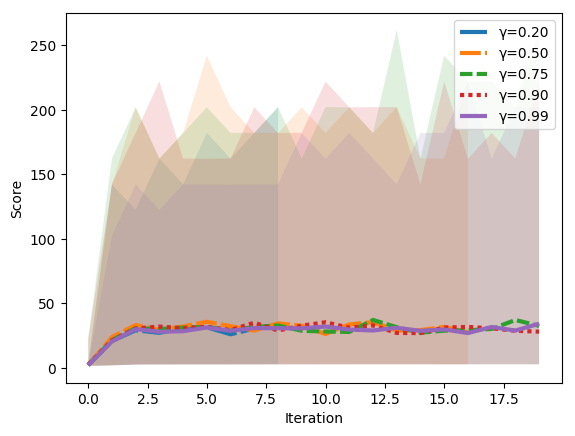

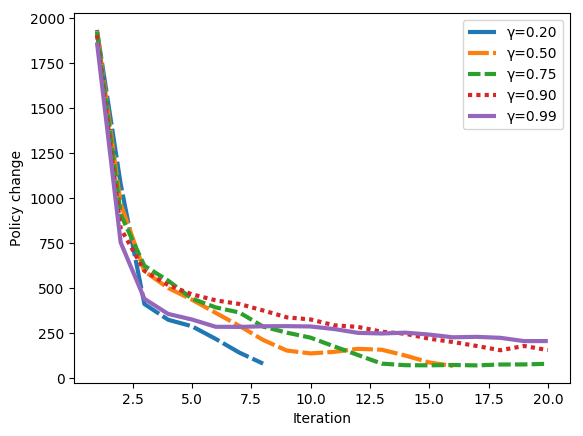

In [20]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 3
alpha_res = 20
x_res = 10
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    print(gama)
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20, reward_gradient_multiplier=1)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

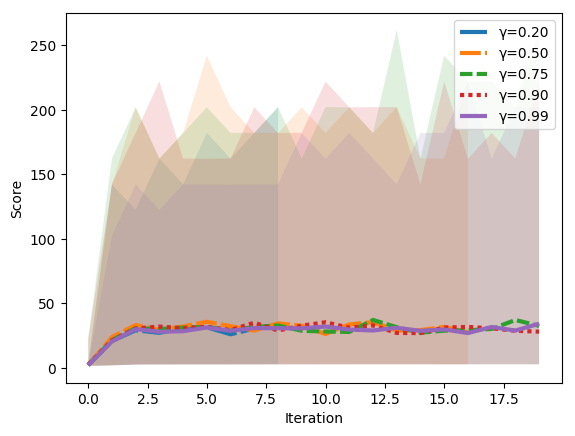

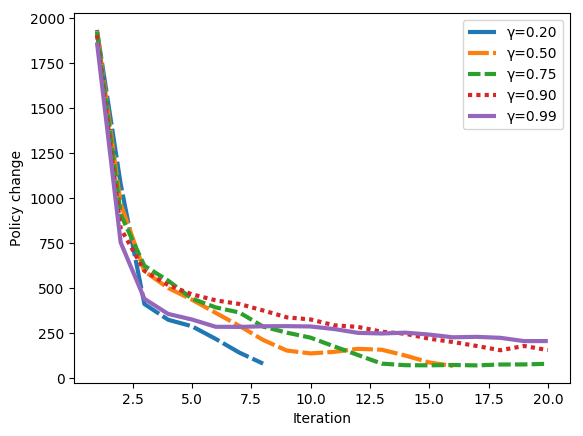

In [21]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 3
alpha_res = 20
x_res = 10
e = 0.001
max_iter = 50

filename = 'R{}_{}_{}_VI_withDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis_gama(records)

### 6. arm 3, alpha res 20, target resolution 10,  reward_gradient 0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4950.61it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2723.80it/s]


dleta = 24.999999999999947
perf = (0.0, 17.2, 140.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2959.48it/s]


dleta = 4.999999999999948
perf = (0.0, 33.3, 180.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2626.34it/s]


dleta = 0.9999360000000008
perf = (0.0, 34.2, 200.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2704.42it/s]


dleta = 0.19998720000000014
perf = (0.0, 27.2, 180.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2662.79it/s]


dleta = 0.03999744000000002
perf = (0.0, 33.1, 200.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2636.94it/s]


dleta = 0.007999488000000006
perf = (0.0, 23.5, 180.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2722.53it/s]


dleta = 0.0015998976000000014
perf = (0.0, 30.5, 180.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2702.78it/s]


dleta = 0.0003199795200000003
perf = (0.0, 27.1, 160.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5467.78it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2633.49it/s]


dleta = 39.99998092651367
perf = (0.0, 16.7, 120.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2926.06it/s]


dleta = 19.999980926513672
perf = (0.0, 29.1, 180.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2746.19it/s]


dleta = 9.84375
perf = (0.0, 26.4, 160.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2851.69it/s]


dleta = 4.921875
perf = (0.0, 31.9, 180.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2934.50it/s]


dleta = 2.4609375
perf = (0.0, 28.9, 180.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2881.89it/s]


dleta = 1.23046875
perf = (0.0, 29.9, 220.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2389.15it/s]


dleta = 0.615234375
perf = (0.0, 27.8, 180.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2922.22it/s]


dleta = 0.3076171875
perf = (0.0, 24.8, 180.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3007.38it/s]


dleta = 0.15380859375
perf = (0.0, 26.7, 200.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2923.93it/s]


dleta = 0.068359375
perf = (0.0, 23.1, 160.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2759.66it/s]


dleta = 0.029296875
perf = (0.0, 28.2, 180.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2434.01it/s]


dleta = 0.009765625
perf = (0.0, 27.1, 240.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2929.38it/s]


dleta = 0.0048828125
perf = (0.0, 29.9, 180.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2801.44it/s]


dleta = 0.00244140625
perf = (0.0, 29.9, 180.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3255.68it/s]


dleta = 0.001220703125
perf = (0.0, 27.8, 200.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2675.14it/s]


dleta = 0.0006103515625
perf = (0.0, 25.8, 200.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5470.20it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2734.26it/s]


dleta = 79.80972728366396
perf = (0.0, 17.8, 180.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2715.41it/s]


dleta = 59.80972728366396
perf = (0.0, 28.2, 200.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2851.78it/s]


dleta = 34.3212890625
perf = (0.0, 28.2, 200.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2831.92it/s]


dleta = 25.740966796875
perf = (0.0, 27.8, 160.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2869.37it/s]


dleta = 19.30572509765625
perf = (0.0, 30.5, 160.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2657.71it/s]


dleta = 14.479293823242188
perf = (0.0, 28.9, 140.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3002.57it/s]


dleta = 10.85947036743164
perf = (0.0, 28.5, 200.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2652.55it/s]


dleta = 7.299900054931641
perf = (0.0, 32.6, 180.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2693.98it/s]


dleta = 4.630222320556641
perf = (0.0, 26.8, 200.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2816.50it/s]


dleta = 2.6279640197753906
perf = (0.0, 27.5, 180.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2862.69it/s]


dleta = 1.695258702384308
perf = (0.0, 25.2, 160.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2687.23it/s]


dleta = 1.0987734608352184
perf = (0.0, 29.2, 220.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2711.92it/s]


dleta = 0.6335270404815674
perf = (0.0, 26.7, 200.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2874.79it/s]


dleta = 0.47514528036117554
perf = (0.0, 25.9, 180.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2896.96it/s]


dleta = 0.35635896027088165
perf = (0.0, 23.2, 220.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2715.55it/s]


dleta = 0.26726922020316124
perf = (0.0, 30.5, 220.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2918.55it/s]


dleta = 0.20045191515237093
perf = (0.0, 28.3, 140.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2736.11it/s]


dleta = 0.1503389363642782
perf = (0.0, 29.8, 180.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2851.41it/s]


dleta = 0.11275420227320865
perf = (0.0, 25.0, 160.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2857.13it/s]


dleta = 0.08456565170490649
perf = (0.0, 23.8, 160.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2764.06it/s]


dleta = 0.06342423877867986
perf = (0.0, 30.3, 200.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2919.64it/s]


dleta = 0.0475681790840099
perf = (0.0, 25.6, 180.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2803.68it/s]


dleta = 0.035676134313007424
perf = (0.0, 28.2, 200.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2733.25it/s]


dleta = 0.026757100734755568
perf = (0.0, 32.6, 240.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2839.09it/s]


dleta = 0.020067825551066676
perf = (0.0, 26.2, 220.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2796.05it/s]


dleta = 0.01505086916330356
perf = (0.0, 27.6, 200.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2952.12it/s]


dleta = 0.01128815187247767
perf = (0.0, 33.1, 220.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2471.56it/s]


dleta = 0.008466113904358252
perf = (0.0, 29.3, 200.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2903.78it/s]


dleta = 0.006349585428271354
perf = (0.0, 28.6, 200.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2811.23it/s]


dleta = 0.004762189071202627
perf = (0.0, 32.1, 200.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2822.56it/s]


dleta = 0.003571641803404191
perf = (0.0, 27.4, 180.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2529.33it/s]


dleta = 0.0026787313525513667
perf = (0.0, 25.1, 180.0)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3001.37it/s]


dleta = 0.002009048514413081
perf = (0.0, 30.7, 220.0)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2780.16it/s]


dleta = 0.0015067863858178043
perf = (0.0, 29.1, 180.0)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2628.26it/s]


dleta = 0.0011300897893633532
perf = (0.0, 31.4, 220.0)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2626.82it/s]


dleta = 0.000847567342027844
perf = (0.0, 29.2, 180.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 5083.33it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2666.55it/s]


dleta = 178.11620217369756
perf = (0.0, 10.6, 140.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2834.58it/s]


dleta = 158.11620217369756
perf = (0.0, 26.4, 200.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2796.96it/s]


dleta = 66.34062
perf = (0.0, 31.6, 160.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2646.66it/s]


dleta = 52.08627578687984
perf = (0.0, 33.2, 220.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2912.94it/s]


dleta = 41.49563553490726
perf = (0.0, 27.1, 180.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2621.73it/s]


dleta = 30.703277031451975
perf = (0.0, 31.5, 200.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2804.06it/s]


dleta = 27.41861790387118
perf = (0.0, 28.0, 200.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2668.01it/s]


dleta = 23.982103110078008
perf = (0.0, 28.9, 220.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2950.85it/s]


dleta = 21.583892799070185
perf = (0.0, 32.4, 200.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3074.25it/s]


dleta = 15.307680877270215
perf = (0.0, 30.0, 200.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2944.98it/s]


dleta = 12.745072858922995
perf = (0.0, 25.7, 160.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2899.63it/s]


dleta = 10.043369423576962
perf = (0.0, 27.9, 180.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2803.64it/s]


dleta = 8.006888403212088
perf = (0.0, 29.9, 200.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2668.65it/s]


dleta = 5.930509210927994
perf = (0.0, 25.2, 180.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2824.68it/s]


dleta = 5.253645779028972
perf = (0.0, 28.8, 200.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2674.12it/s]


dleta = 4.255453081013471
perf = (0.0, 32.1, 200.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2614.76it/s]


dleta = 3.706040377703701
perf = (0.0, 25.4, 200.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2949.69it/s]


dleta = 3.335436339933324
perf = (0.0, 27.7, 160.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2702.45it/s]


dleta = 3.0018927059399942
perf = (0.0, 26.6, 240.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2957.86it/s]


dleta = 2.7017034353460048
perf = (0.0, 30.4, 180.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2804.38it/s]


dleta = 2.431533091811403
perf = (0.0, 26.5, 180.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2744.18it/s]


dleta = 2.188379782630264
perf = (0.0, 25.7, 180.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2756.32it/s]


dleta = 1.969541804367239
perf = (0.0, 26.9, 200.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.75it/s]


dleta = 1.7725876239305052
perf = (0.0, 27.0, 180.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2929.97it/s]


dleta = 1.5953288615374532
perf = (0.0, 23.7, 180.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2883.26it/s]


dleta = 1.4357959753837122
perf = (0.0, 29.3, 180.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2835.92it/s]


dleta = 1.2922163778453637
perf = (0.0, 30.2, 180.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2788.66it/s]


dleta = 1.1629947400608245
perf = (0.0, 33.4, 220.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3015.07it/s]


dleta = 1.0466952660547548
perf = (0.0, 26.4, 220.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2649.99it/s]


dleta = 0.9420257394492921
perf = (0.0, 28.8, 160.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3053.99it/s]


dleta = 0.8478231655043658
perf = (0.0, 31.7, 220.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2990.08it/s]


dleta = 0.7630408489539349
perf = (0.0, 27.2, 240.0)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2747.54it/s]


dleta = 0.6867367640585229
perf = (0.0, 28.8, 200.0)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2850.48it/s]


dleta = 0.618063087652672
perf = (0.0, 26.6, 140.0)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2936.94it/s]


dleta = 0.5562567788874162
perf = (0.0, 29.0, 220.0)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2900.71it/s]


dleta = 0.5006311009986746
perf = (0.0, 28.1, 220.0)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2868.15it/s]


dleta = 0.4505679908988043
perf = (0.0, 27.7, 160.0)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3041.03it/s]


dleta = 0.4055111918089267
perf = (0.0, 28.4, 180.0)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2761.33it/s]


dleta = 0.36496007262802266
perf = (0.0, 27.8, 200.0)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2892.79it/s]


dleta = 0.32846406536522466
perf = (0.0, 25.6, 160.0)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3018.01it/s]


dleta = 0.2956176588287036
perf = (0.0, 34.3, 200.0)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2911.58it/s]


dleta = 0.266055892945829
perf = (0.0, 26.3, 160.0)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2914.95it/s]


dleta = 0.23945030365123898
perf = (0.0, 24.2, 180.0)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2261.20it/s]


dleta = 0.21550527328611224
perf = (0.0, 24.9, 180.0)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2675.64it/s]


dleta = 0.1939547459575124
perf = (0.0, 27.2, 200.0)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2677.28it/s]


dleta = 0.17455927136177252
perf = (0.0, 27.7, 220.0)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2824.71it/s]


dleta = 0.15710334422558958
perf = (0.0, 34.0, 200.0)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2713.37it/s]


dleta = 0.14139300980303915
perf = (0.0, 24.7, 200.0)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1922.11it/s]


dleta = 0.12725370882273523
perf = (0.0, 28.9, 200.0)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2995.11it/s]


dleta = 0.11452833794047024
perf = (0.0, 29.2, 200.0)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4964.64it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2943.72it/s]


dleta = 402.62827008885864
perf = (0.0, 20.4, 140.0)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3010.00it/s]


dleta = 394.61596751409036
perf = (0.0, 25.1, 140.0)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2961.17it/s]


dleta = 291.81352748386854
perf = (0.0, 30.8, 160.0)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2520.66it/s]


dleta = 238.67630861377643
perf = (0.0, 28.0, 160.0)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2993.07it/s]


dleta = 195.21500865530493
perf = (0.0, 31.0, 160.0)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2959.71it/s]


dleta = 159.66770990227724
perf = (0.0, 27.1, 200.0)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2999.29it/s]


dleta = 130.59332763933457
perf = (0.0, 27.3, 160.0)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3042.79it/s]


dleta = 106.81318868012045
perf = (0.0, 26.5, 140.0)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2857.75it/s]


dleta = 87.36324804835249
perf = (0.0, 29.7, 140.0)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2965.85it/s]


dleta = 71.45500666977546
perf = (0.0, 27.2, 180.0)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2971.02it/s]


dleta = 58.44354568126528
perf = (0.0, 26.6, 140.0)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2937.31it/s]


dleta = 53.21878541595993
perf = (0.0, 26.2, 120.0)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2832.49it/s]


dleta = 52.68659756180034
perf = (0.0, 27.6, 160.0)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2960.47it/s]


dleta = 50.610535398341085
perf = (0.0, 28.7, 180.0)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2816.03it/s]


dleta = 48.61627836761022
perf = (0.0, 29.1, 180.0)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3047.60it/s]


dleta = 46.70060302097568
perf = (0.0, 31.6, 180.0)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2950.74it/s]


dleta = 44.86041292654318
perf = (0.0, 29.9, 160.0)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2927.80it/s]


dleta = 43.092733664189836
perf = (0.0, 30.4, 160.0)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2864.90it/s]


dleta = 42.66180632754799
perf = (0.0, 32.3, 180.0)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2978.69it/s]


dleta = 40.98076093763518
perf = (0.0, 28.1, 160.0)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2938.40it/s]


dleta = 39.36595544345619
perf = (0.0, 26.6, 140.0)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2554.39it/s]


dleta = 37.814779728822145
perf = (0.0, 30.4, 180.0)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2508.49it/s]


dleta = 36.32472652653519
perf = (0.0, 27.1, 140.0)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2630.75it/s]


dleta = 34.89338736573109
perf = (0.0, 25.8, 160.0)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2664.91it/s]


dleta = 33.51844867890554
perf = (0.0, 28.6, 160.0)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2885.53it/s]


dleta = 33.18326419211667
perf = (0.0, 26.6, 160.0)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2881.63it/s]


dleta = 31.875711181722863
perf = (0.0, 29.1, 180.0)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2868.82it/s]


dleta = 30.61968097707563
perf = (0.0, 30.6, 180.0)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2656.67it/s]


dleta = 29.413143374051515
perf = (0.0, 28.7, 180.0)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2926.54it/s]


dleta = 28.25414816667194
perf = (0.0, 26.6, 160.0)
Iteration #30


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2578.15it/s]


dleta = 27.14082199485415
perf = (0.0, 28.8, 160.0)
Iteration #31


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2544.43it/s]


dleta = 26.07136531637707
perf = (0.0, 36.2, 180.0)
Iteration #32


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3084.75it/s]


dleta = 25.810651663213093
perf = (0.0, 28.1, 160.0)
Iteration #33


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2995.06it/s]


dleta = 24.793609003181928
perf = (0.0, 25.2, 160.0)
Iteration #34


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2729.64it/s]


dleta = 23.81664188195691
perf = (0.0, 31.0, 220.0)
Iteration #35


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3016.07it/s]


dleta = 22.87817116340716
perf = (0.0, 26.9, 180.0)
Iteration #36


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2999.34it/s]


dleta = 21.976679935665743
perf = (0.0, 30.4, 200.0)
Iteration #37


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3096.43it/s]


dleta = 21.333804824051413
perf = (0.0, 22.1, 160.0)
Iteration #38


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2833.78it/s]


dleta = 20.7001694869723
perf = (0.0, 27.9, 180.0)
Iteration #39


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3065.24it/s]


dleta = 20.08535375304018
perf = (0.0, 22.9, 160.0)
Iteration #40


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2899.92it/s]


dleta = 19.48879866122047
perf = (0.0, 28.8, 200.0)
Iteration #41


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3012.68it/s]


dleta = 18.909961852184324
perf = (0.0, 33.7, 180.0)
Iteration #42


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3004.43it/s]


dleta = 18.533653611325462
perf = (0.0, 27.6, 160.0)
Iteration #43


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2937.56it/s]


dleta = 17.983185565415397
perf = (0.0, 27.3, 180.0)
Iteration #44


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2648.97it/s]


dleta = 17.542092559371667
perf = (0.0, 27.1, 180.0)
Iteration #45


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2985.20it/s]


dleta = 17.109582738250992
perf = (0.0, 31.2, 200.0)
Iteration #46


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2989.76it/s]


dleta = 16.769102041760107
perf = (0.0, 26.0, 140.0)
Iteration #47


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2895.12it/s]


dleta = 16.43539691112892
perf = (0.0, 31.0, 200.0)
Iteration #48


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3002.54it/s]


dleta = 16.1083325125976
perf = (0.0, 33.1, 180.0)
Iteration #49


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2999.80it/s]


dleta = 15.787776695596676
perf = (0.0, 28.1, 200.0)


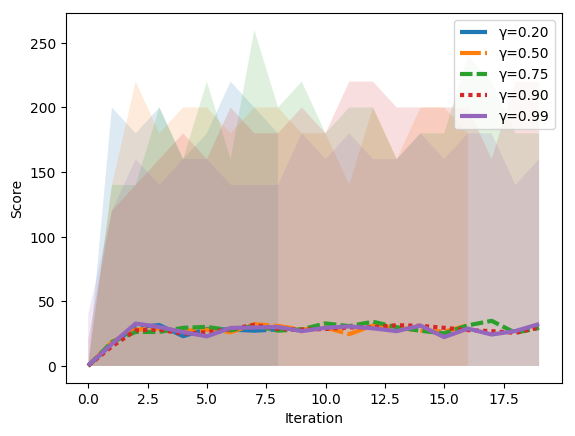

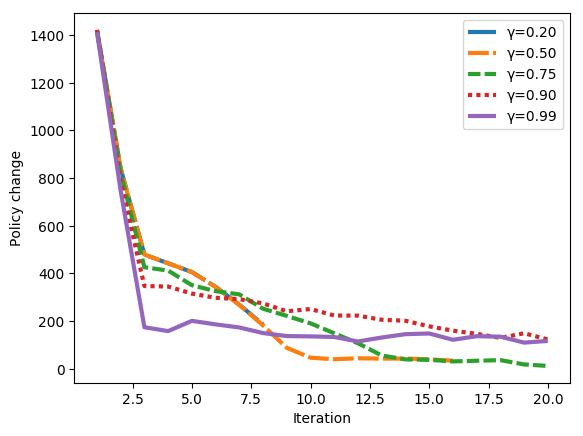

In [22]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 3
alpha_res = 20
x_res = 10
e = 0.001
max_iter = 50
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20, reward_gradient_multiplier=0)
    states_pi,rec = valueIteration(game, e, gama, max_iter=max_iter)
    policies["γ={:0.2f}".format(gama)] = states_pi
    records["γ={:0.2f}".format(gama)] = rec
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis_gama(records)

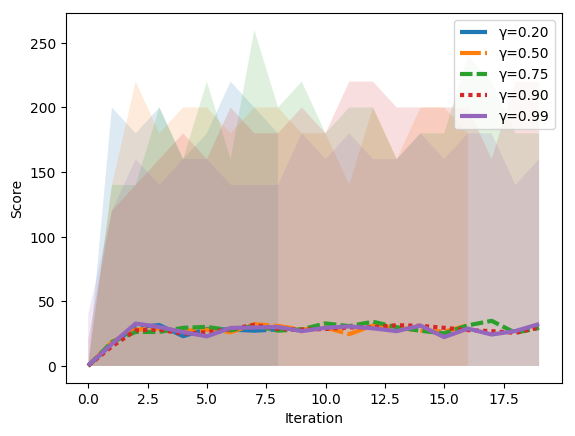

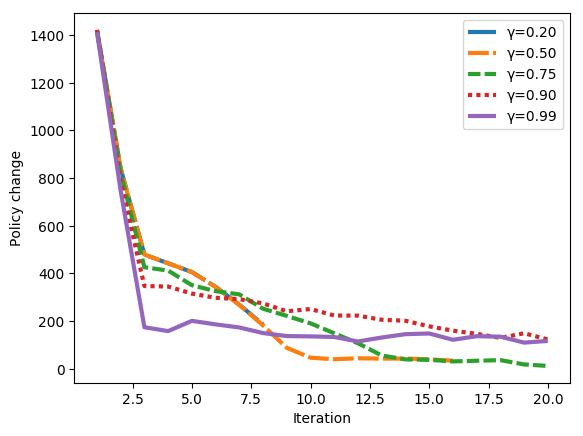

In [23]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 3
alpha_res = 20
x_res = 10
e = 0.001
max_iter = 50
filename = 'R{}_{}_{}_VI_noDistanceReward_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis_gama(records)

# Policy Iteration

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3071.40it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1620.79it/s]


perf = (128.1153449513548, 255.42729701485635, 367.31751820026443)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1535.50it/s]


perf = (167.55221807626225, 260.90857781910637, 427.27946042737653)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1502.77it/s]


perf = (107.97893010491123, 259.1052734475021, 367.41253559575694)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1500.71it/s]


perf = (167.59275095310224, 259.7098060448427, 387.34706668142167)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1628.66it/s]


perf = (147.36685922203068, 261.0057098587986, 407.38262079470724)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1660.73it/s]


perf = (147.52924723663094, 260.71466481426677, 407.1970829432897)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1650.62it/s]


perf = (167.5247033184453, 257.011666911504, 387.3178023354182)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1619.28it/s]


perf = (167.61935560814175, 273.791730080415, 427.26926088686605)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2961.46it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1690.34it/s]


perf = (8.045335986617147, 217.01986312753567, 367.44251095663753)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1581.28it/s]


perf = (167.59719826152207, 264.39761068609516, 367.3094804027393)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1657.72it/s]


perf = (167.5071043915836, 267.18699397290936, 427.21469850858097)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1592.81it/s]


perf = (167.5606419859231, 267.9837605767968, 387.3474844439803)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1601.38it/s]


perf = (187.50669693853547, 269.46910140462256, 387.35488647743773)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1618.94it/s]


perf = (167.484231549547, 267.3791040904075, 367.3569945617341)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1652.57it/s]


perf = (167.5033345597713, 270.76174459685956, 387.2736672778957)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1736.41it/s]


perf = (187.46660059372397, 273.87389177746417, 447.2777310568802)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1763.09it/s]


perf = (167.51875122512695, 269.76977016414884, 367.40669812881566)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1737.20it/s]


perf = (187.59230862359746, 274.4759437231429, 407.29203040451)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1712.92it/s]


perf = (187.3903312628866, 273.56522034548004, 427.1848524533896)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1735.15it/s]


perf = (167.37838278576928, 274.866823232956, 427.27708643122344)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1749.77it/s]


perf = (167.5176488083358, 270.3669625066874, 387.3628266445117)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1762.75it/s]


perf = (187.41510488162336, 267.4623736972476, 427.27060155448663)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3115.75it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2100.42it/s]


perf = (6.181364604256511, 16.952683202926664, 127.8380672371567)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1800.92it/s]


perf = (28.28879115737917, 250.53162386142404, 367.3539233245641)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1754.70it/s]


perf = (187.38514060775867, 268.5819530241243, 367.3637790489461)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1776.85it/s]


perf = (167.5218626467089, 271.2875750000939, 387.3798275709398)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1819.97it/s]


perf = (187.51474478804383, 273.3723888402318, 407.38161096365224)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1772.04it/s]


perf = (187.47579713378968, 272.6704422993168, 427.301295844669)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1721.24it/s]


perf = (187.5170218953794, 269.37406344155266, 407.40638838131053)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1790.74it/s]


perf = (187.44034375278397, 271.05869493509755, 427.231013593613)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1770.31it/s]


perf = (187.428716877524, 275.5583157676054, 407.31043746412615)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1735.11it/s]


perf = (187.30925665652325, 269.5437634472006, 427.1739739075794)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1678.66it/s]


perf = (187.4064700889375, 276.338065653797, 387.3039544435542)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1749.56it/s]


perf = (167.4203959421071, 268.8584490747203, 367.3439544717182)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1719.90it/s]


perf = (187.61166051469132, 275.0478694253633, 387.37205982017235)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1746.07it/s]


perf = (167.34562315241854, 276.6449109355599, 407.37620591908615)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1708.86it/s]


perf = (187.3945800914675, 270.46017130194525, 367.3429260003772)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1753.34it/s]


perf = (187.51031518334287, 277.242024093255, 407.1989567415243)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1633.38it/s]


perf = (187.49451327297956, 278.152332646648, 407.2928118163715)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1710.83it/s]


perf = (187.50056582065685, 274.85060249922475, 367.39332529021)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3095.04it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2098.88it/s]


perf = (6.135630837335833, 7.064684702868158, 8.279493249745466)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2018.02it/s]


perf = (6.204370173741817, 17.787258423438637, 187.38226120458856)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1809.54it/s]


perf = (7.8797171171384885, 161.12486687253218, 347.3627181882912)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1736.29it/s]


perf = (167.52301480163192, 267.07069265179655, 367.3680050276296)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1770.18it/s]


perf = (167.66190485886568, 267.36450493332023, 407.3431471305133)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1749.01it/s]


perf = (167.5194723373362, 267.56598475177407, 387.28872331211454)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1765.98it/s]


perf = (187.51459828866535, 273.35212339496775, 367.3534610270242)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1821.56it/s]


perf = (207.38786220649357, 271.5648573515119, 387.3130047413927)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1648.94it/s]


perf = (187.4952030520295, 274.1644756681975, 367.3591331735351)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1723.56it/s]


perf = (207.32019878668262, 275.55414833900164, 427.15086718901296)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1561.32it/s]


perf = (167.49710942821784, 276.65506834218155, 427.2399831998363)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1675.06it/s]


perf = (187.4517927024955, 278.04230207421557, 387.1889200975769)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1711.70it/s]


perf = (207.39709292254318, 276.3519679981601, 387.29630860141066)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1581.08it/s]


perf = (187.35465898227818, 273.7541352579106, 427.18257032369775)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1566.21it/s]


perf = (187.56157641915559, 273.15907037024726, 367.42197913003315)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1648.40it/s]


perf = (167.40121717099265, 278.04857629633335, 387.3903878419556)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1554.92it/s]


perf = (187.34274356468578, 272.1441149125179, 447.1077498077079)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1608.30it/s]


perf = (207.36333619252548, 272.85467694694574, 367.3515943928644)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1497.94it/s]


perf = (167.43696872421302, 272.7418757110865, 407.2309575182886)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1612.25it/s]


perf = (187.37525054007554, 281.14869183740007, 407.43570954321814)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1575.31it/s]


perf = (187.44280916588195, 275.54664318673395, 407.22568471361234)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1372.11it/s]


perf = (187.39081381036013, 274.65311156951225, 387.35015492418637)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1653.81it/s]


perf = (167.53793913967735, 276.8459759427108, 387.3711705442417)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1541.29it/s]


perf = (167.41730572875665, 268.25878769276846, 447.2205047591333)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1470.86it/s]


perf = (167.5232086137978, 275.93562496944605, 427.2064323598565)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1661.93it/s]


perf = (187.46055394255586, 274.250399712211, 387.3202076869695)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1639.62it/s]


perf = (187.56556896051728, 274.94833681130706, 387.3079115868084)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1625.60it/s]


perf = (167.5258870549227, 272.45350417968797, 387.3936638837581)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1643.21it/s]


perf = (207.4753765951788, 280.047929285378, 407.265901774797)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1523.45it/s]


perf = (187.4576846422323, 276.0484164082263, 407.2866949547771)


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3016.27it/s]


Iteration #0


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1977.22it/s]


perf = (6.20218254752865, 7.01982138163254, 8.045588911998722)
Iteration #1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2031.38it/s]


perf = (6.233160478767053, 7.839671428329491, 67.84585466288638)
Iteration #2


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2033.25it/s]


perf = (6.033309280804749, 12.085409834556106, 87.95782652416912)
Iteration #3


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1925.22it/s]


perf = (6.088178642039964, 25.88680716921037, 207.31391131816355)
Iteration #4


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1892.98it/s]


perf = (6.398780925392536, 76.91466414594282, 327.3835252071635)
Iteration #5


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1814.53it/s]


perf = (6.509316895419218, 132.54829394295132, 367.26216132857144)
Iteration #6


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1682.24it/s]


perf = (7.25814642109052, 202.62923741705902, 347.31452404523935)
Iteration #7


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1642.76it/s]


perf = (47.075996848840724, 251.95731494398672, 407.31843107408616)
Iteration #8


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1688.39it/s]


perf = (167.52864935487392, 263.46365216981104, 407.2895639620195)
Iteration #9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1505.52it/s]


perf = (167.38115483720776, 260.56519270129536, 407.33916510992907)
Iteration #10


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1498.63it/s]


perf = (187.39621867159485, 271.6546647935854, 407.18151075419394)
Iteration #11


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1332.21it/s]


perf = (187.4986743865387, 268.16342473755975, 487.11130203508304)
Iteration #12


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1611.29it/s]


perf = (207.3641692836517, 274.3478056430176, 427.1418708853261)
Iteration #13


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1653.41it/s]


perf = (187.27233975802437, 270.8495686218611, 427.21740045524575)
Iteration #14


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1673.65it/s]


perf = (187.54009228930374, 268.7504265932544, 407.1957955984863)
Iteration #15


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1594.23it/s]


perf = (187.47821403115873, 267.4502904146097, 367.34666144686156)
Iteration #16


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1562.08it/s]


perf = (187.3990922429964, 268.8436705784777, 367.3632601707703)
Iteration #17


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1339.63it/s]


perf = (187.33921449536695, 274.9416050432285, 387.2432888032331)
Iteration #18


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1476.00it/s]


perf = (187.5220147287223, 276.7353125097894, 387.3026600637364)
Iteration #19


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1444.11it/s]


perf = (187.28697772257888, 272.8373352941372, 407.2360569270703)
Iteration #20


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1538.48it/s]


perf = (187.43666057374455, 276.5300102840072, 427.2322375465355)
Iteration #21


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1538.60it/s]


perf = (207.16892067844987, 277.22499743809055, 467.1896344784859)
Iteration #22


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1481.19it/s]


perf = (187.37821872624843, 277.2222667960977, 367.295849349341)
Iteration #23


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1598.66it/s]


perf = (187.46454386712924, 274.1342994013657, 387.2443384889923)
Iteration #24


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1497.37it/s]


perf = (187.54517431202, 275.0292075291684, 387.2971163287666)
Iteration #25


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1582.40it/s]


perf = (187.308508837336, 275.4347525611104, 387.3301189720355)
Iteration #26


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1512.41it/s]


perf = (187.34729735923608, 273.73129770888676, 387.3748581017527)
Iteration #27


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1491.53it/s]


perf = (187.40776175230576, 279.5302221370867, 407.32192817429257)
Iteration #28


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1569.25it/s]


perf = (187.48739963707916, 275.940700098622, 367.3486603254604)
Iteration #29


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1507.06it/s]


perf = (207.41991919461222, 277.3206694676479, 407.1895019096527)


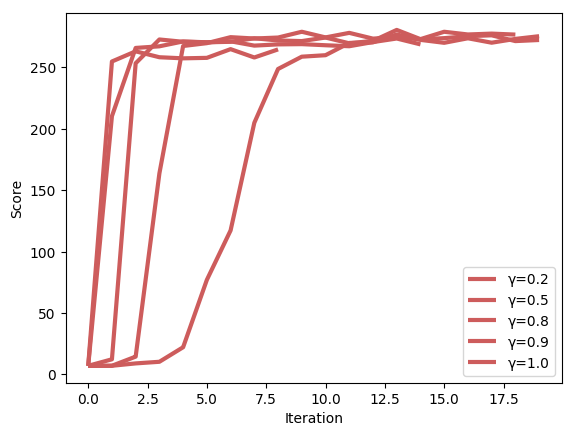

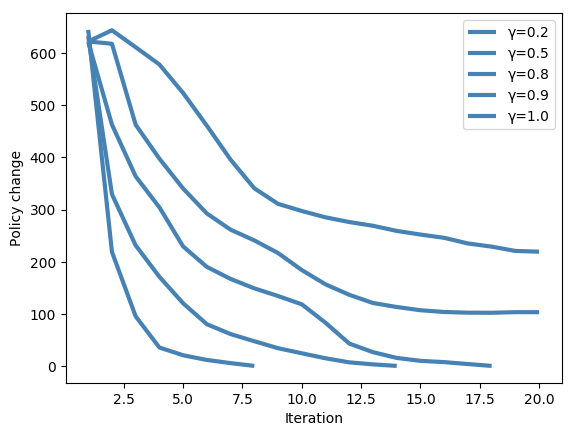

In [24]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
max_iter = 30
eval_iter = 10
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20)
    states_pi,rec = policyIteration(game, gama, eval_iter=eval_iter, max_iter=max_iter)
    policies["γ={:0.1f}".format(gama)] = states_pi
    records["γ={:0.1f}".format(gama)] = rec
filename = 'R{}_{}_{}_PI_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

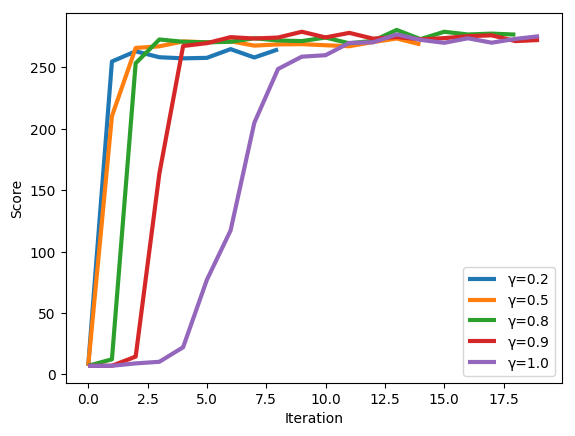

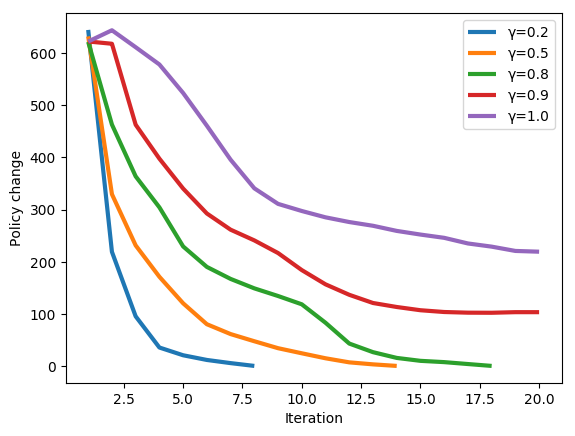

In [38]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
max_iter = 30
eval_iter = 10
policies = {}
records = {}
filename = 'R{}_{}_{}_PI_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis(records)

# Q Learning

In [42]:
arm_nbr = 2
alpha_res = 60
x_res = 6
gama = 0.5
alpha = 0.5
qinit = 0
qpolicy = eGreedy
nbr_episode = 1000
nbr_turns = 100
rec_period = 50
policies = {}
records = {}

In [43]:
qpolicy_args = {'epsilon':0.2}
game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20)
states_pi, rec = Qlearning(game, gama, alpha, qpolicy=qpolicy, 
                           qpolicy_args=qpolicy_args, qinit=0, 
                           nbr_turns=nbr_turns, nbr_episode=nbr_episode, 
                           rec_period=rec_period, verbose=False)
policies["e-Greedy"] = states_pi
records["e-Greedy"] = rec

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:54<00:00,  1.87it/s]


In [44]:
qpolicy_args = {'epsilon':0.05}
game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20)
states_pi, rec = Qlearning(game, gama, alpha, qpolicy=qpolicy, 
                           qpolicy_args=qpolicy_args, qinit=5, 
                           nbr_turns=nbr_turns, nbr_episode=nbr_episode, 
                           rec_period=rec_period, verbose=False)
policies["Optimistic init"] = states_pi
records["Optimistic init"] = rec

100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:05<00:00,  1.50it/s]


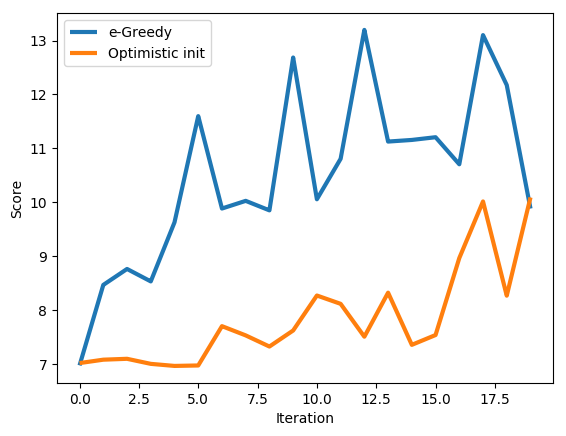

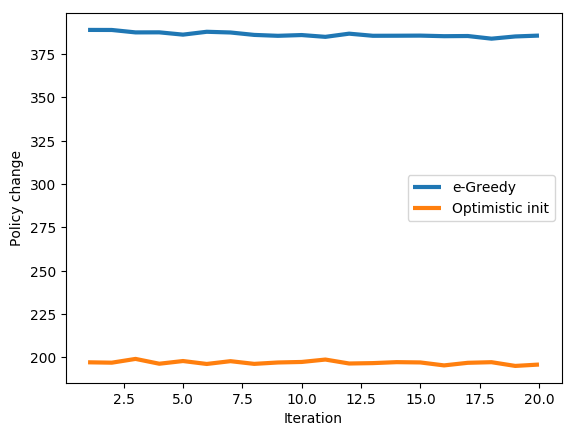

In [46]:
filename = 'R{}_{}_{}_QL_exploStrats'.format(arm_nbr,alpha_res,x_res)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()
analysis(records)

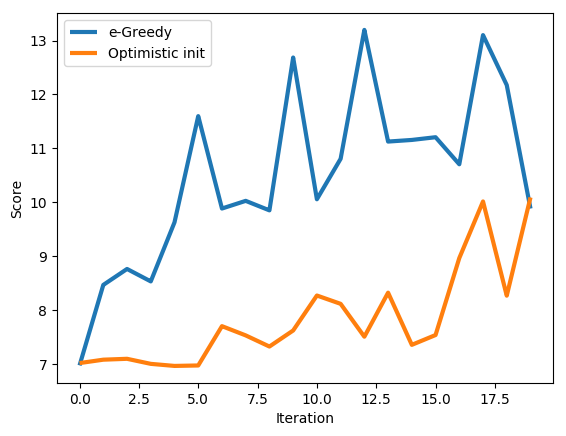

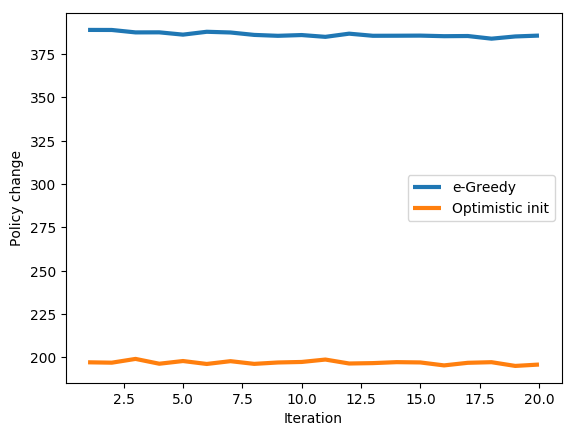

In [47]:
arm_nbr = 2
alpha_res = 60
x_res = 6
gama = 0.5
alpha = 0.5
qinit = 0
qpolicy = eGreedy
nbr_episode = 1000
nbr_turns = 100
rec_period = 50
policies = {}
records = {}
filename = 'R{}_{}_{}_QL_exploStrats'.format(arm_nbr,alpha_res,x_res)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis(records)

In [30]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
alpha = 0.5
qinit = 0
qpolicy = eGreedy
qpolicy_args = {'epsilon':0.2}
nbr_episode = 1000
nbr_turns = 200
rec_period = 100
policies = {}
records = {}
for gama in gamas:
    game = Reacher(arm_nbr=arm_nbr, alpha_res=alpha_res, x_res=x_res, reward_reach=20)
    states_pi,rec = Qlearning(game,gama, alpha, qpolicy=qpolicy, 
                              qpolicy_args=qpolicy_args, qinit=0,
                              nbr_turns=nbr_turns, nbr_episode=nbr_episode, 
                              rec_period=rec_period, verbose=False)
    policies["γ={:0.1f}".format(gama)] = states_pi
    records["γ={:0.1f}".format(gama)] = rec
filename = 'R{}_{}_{}_QL_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
outfile = open(filename,'wb')
pickle.dump((policies,records),outfile)
outfile.close()


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:39<00:00,  1.56it/s]


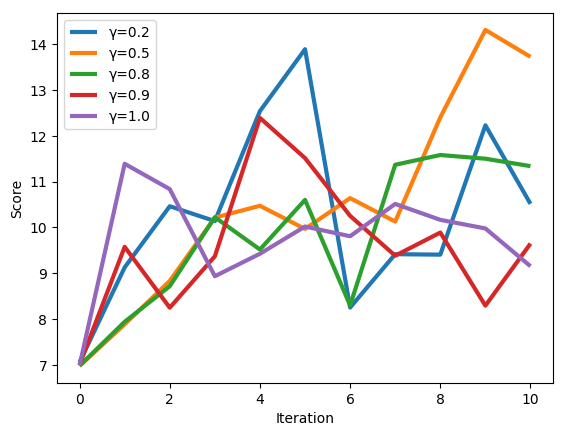

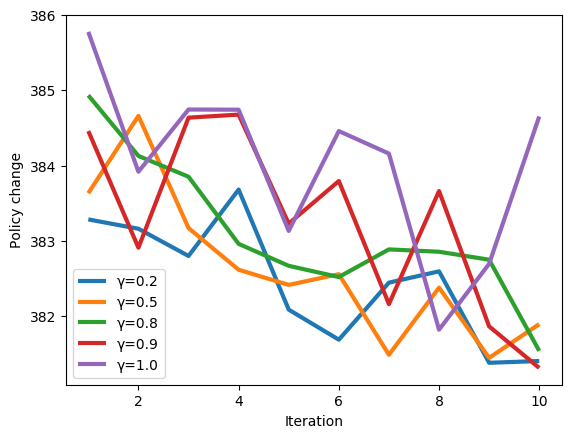

In [48]:
gamas = [0.2,0.5,0.75,0.9,0.99]
arm_nbr = 2
alpha_res = 60
x_res = 6
alpha = 0.5
qinit = 0
qpolicy = eGreedy
qpolicy_args = {'epsilon':0.2}
nbr_episode = 1000
nbr_turns = 200
rec_period = 100
filename = 'R{}_{}_{}_QL_γs={}'.format(arm_nbr,alpha_res,x_res,gamas)
loadfile = open(filename,'rb')

policies,records = pickle.load(loadfile)
# print(records)
analysis(records)

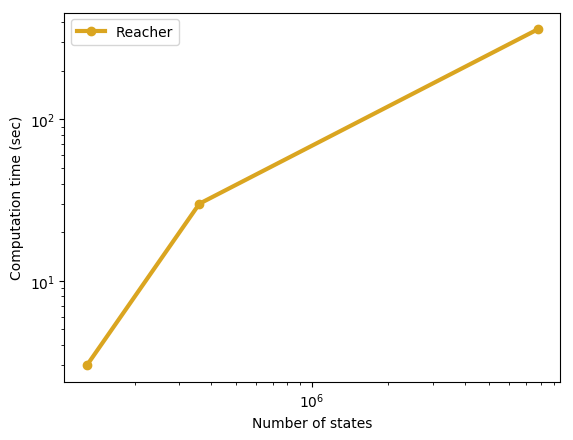

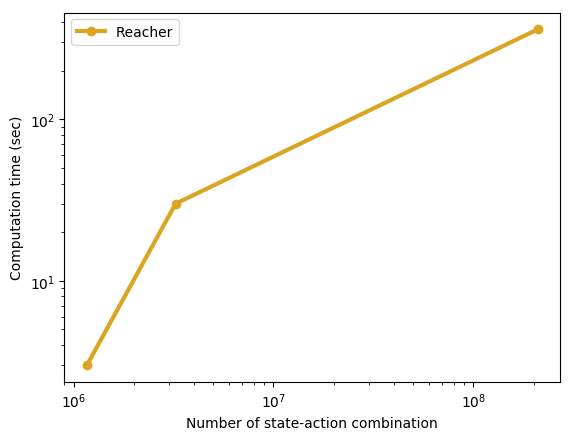

In [49]:
comput_time_VI_R = [3, 30 , 6*60]
nbr_s_VI_R = [60*60*6*6 , 100*100*6*6 , 60*60*60*6*6]
nbr_sa_VI_R = [9*60*60*6*6 , 9*100*100*6*6 , 27*60*60*60*6*6]

plt.plot(nbr_s_VI_R, comput_time_VI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
# plt.xlim(10**5,10**7)
plt.yscale('log')
plt.xlabel("Number of states")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()
plt.plot(nbr_sa_VI_R, comput_time_VI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of state-action combination")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()

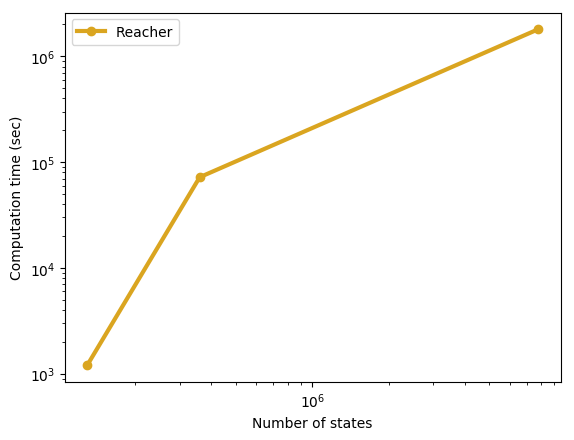

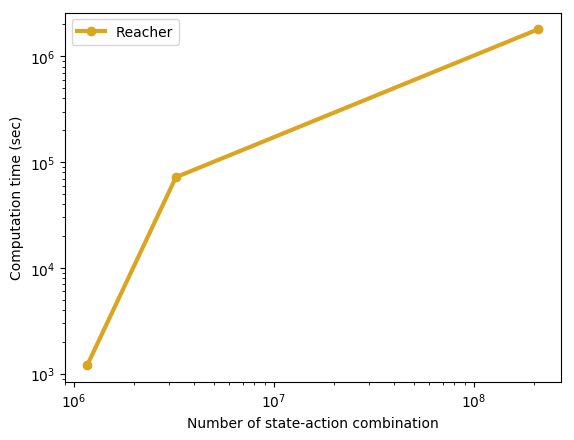

In [32]:
comput_time_PI_R = [20*60 , 20*60*60 , 500*60*60]
nbr_s_PI_R = [60*60*6*6 , 100*100*6*6 , 60*60*60*6*6]
nbr_sa_PI_R = [9*60*60*6*6 , 9*100*100*6*6 , 27*60*60*60*6*6]

plt.plot(nbr_s_PI_R, comput_time_PI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of states")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()
plt.plot(nbr_sa_PI_R, comput_time_PI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of state-action combination")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()

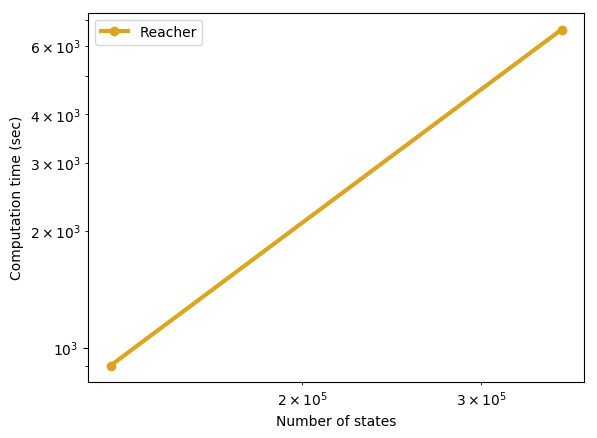

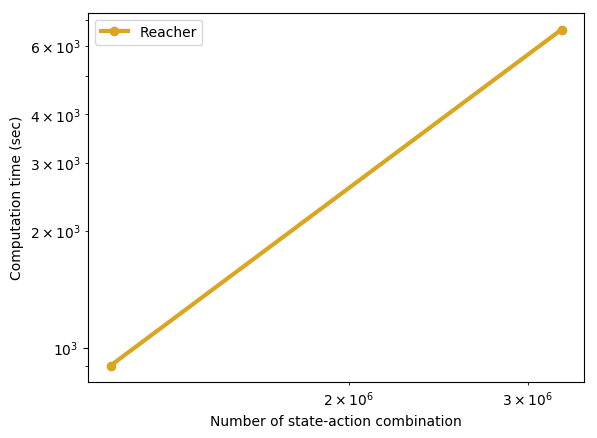

In [33]:
comput_time_QL_R = [900, 6600]
nbr_s_QL_R = [60*60*6*6 , 100*100*6*6]
nbr_sa_QL_R = [9*60*60*6*6 , 9*100*100*6*6]

plt.plot(nbr_s_QL_R, comput_time_QL_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
# plt.xlim(10**5,10**7)
plt.yscale('log')
plt.xlabel("Number of states")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()
plt.plot(nbr_sa_QL_R, comput_time_QL_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of state-action combination")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()

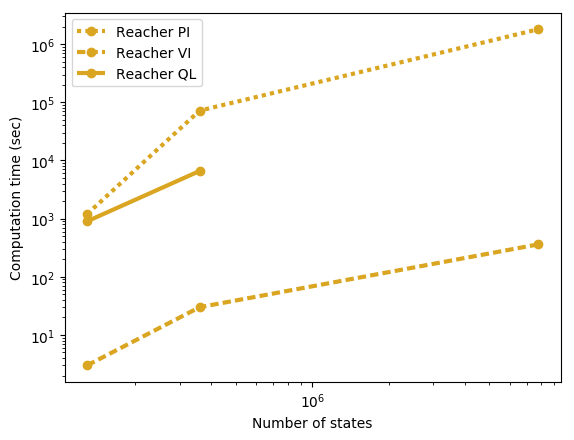

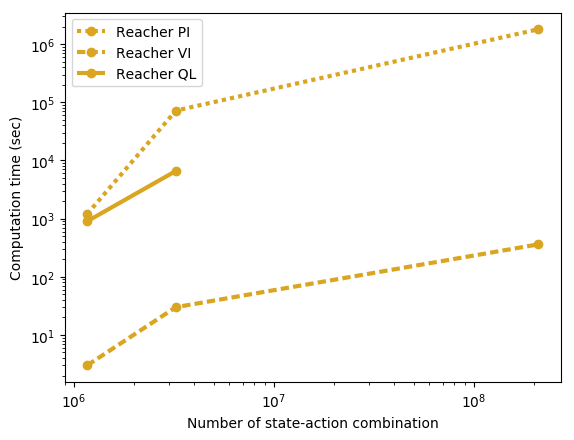

In [50]:
plt.plot(nbr_s_PI_R, comput_time_PI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher PI", dashes=[1,1])
plt.plot(nbr_s_VI_R, comput_time_VI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher VI", dashes=[2,1])
plt.plot(nbr_s_QL_R, comput_time_QL_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher QL", dashes=[2,0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of states")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()
plt.plot(nbr_sa_PI_R, comput_time_PI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher PI", dashes=[1,1])
plt.plot(nbr_sa_VI_R, comput_time_VI_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher VI", dashes=[2,1])
plt.plot(nbr_sa_QL_R, comput_time_QL_R, marker='o', color="GoldenRod", linewidth=3, label="Reacher QL", dashes=[2,0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of state-action combination")
plt.ylabel("Computation time (sec)")
plt.legend()
plt.show()